# Solving PDE with Neural Networks 

In [1]:
%matplotlib inline
import jax.numpy as jnp
import numpy as np
import numpy as onp
import jax
import seaborn as sns
from matplotlib import pyplot as plt
from jax.lib import xla_bridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from matplotlib import animation
import tensorflow as tf
from tensorflow import keras
import ADAMLL as ada
from ADAMLL.activations import relu, sigmoid, eye, tanh
print("jax backend {}".format(xla_bridge.get_backend().platform))

jax backend gpu


## Initial and boundry conditions

In [2]:
dx=0.1 #space increment
dt=0.05 #time increment
tmin=0.0 #initial time
tmax=3.0 #simulate until
xmin=-5.0 #left bound
xmax=5.0 #right bound
c=1.0 #speed of sound
rsq=(c*dt/dx)**2 #appears in finite diff sol

nx = int((xmax-xmin)/dx) + 1 #number of points on x grid
nt = int((tmax-tmin)/dt) + 2 #number of points on t grid
print("nx = ", nx)
print("nt = ", nt)

# set initial pulse shape
def init_fn(x):
    val = np.exp(-(x**2)/0.25)
    return val
    # if val<.001:
    #     return 0.0
    # else:
    #     return val

nx =  101
nt =  62


## Analytical solution of the PDE

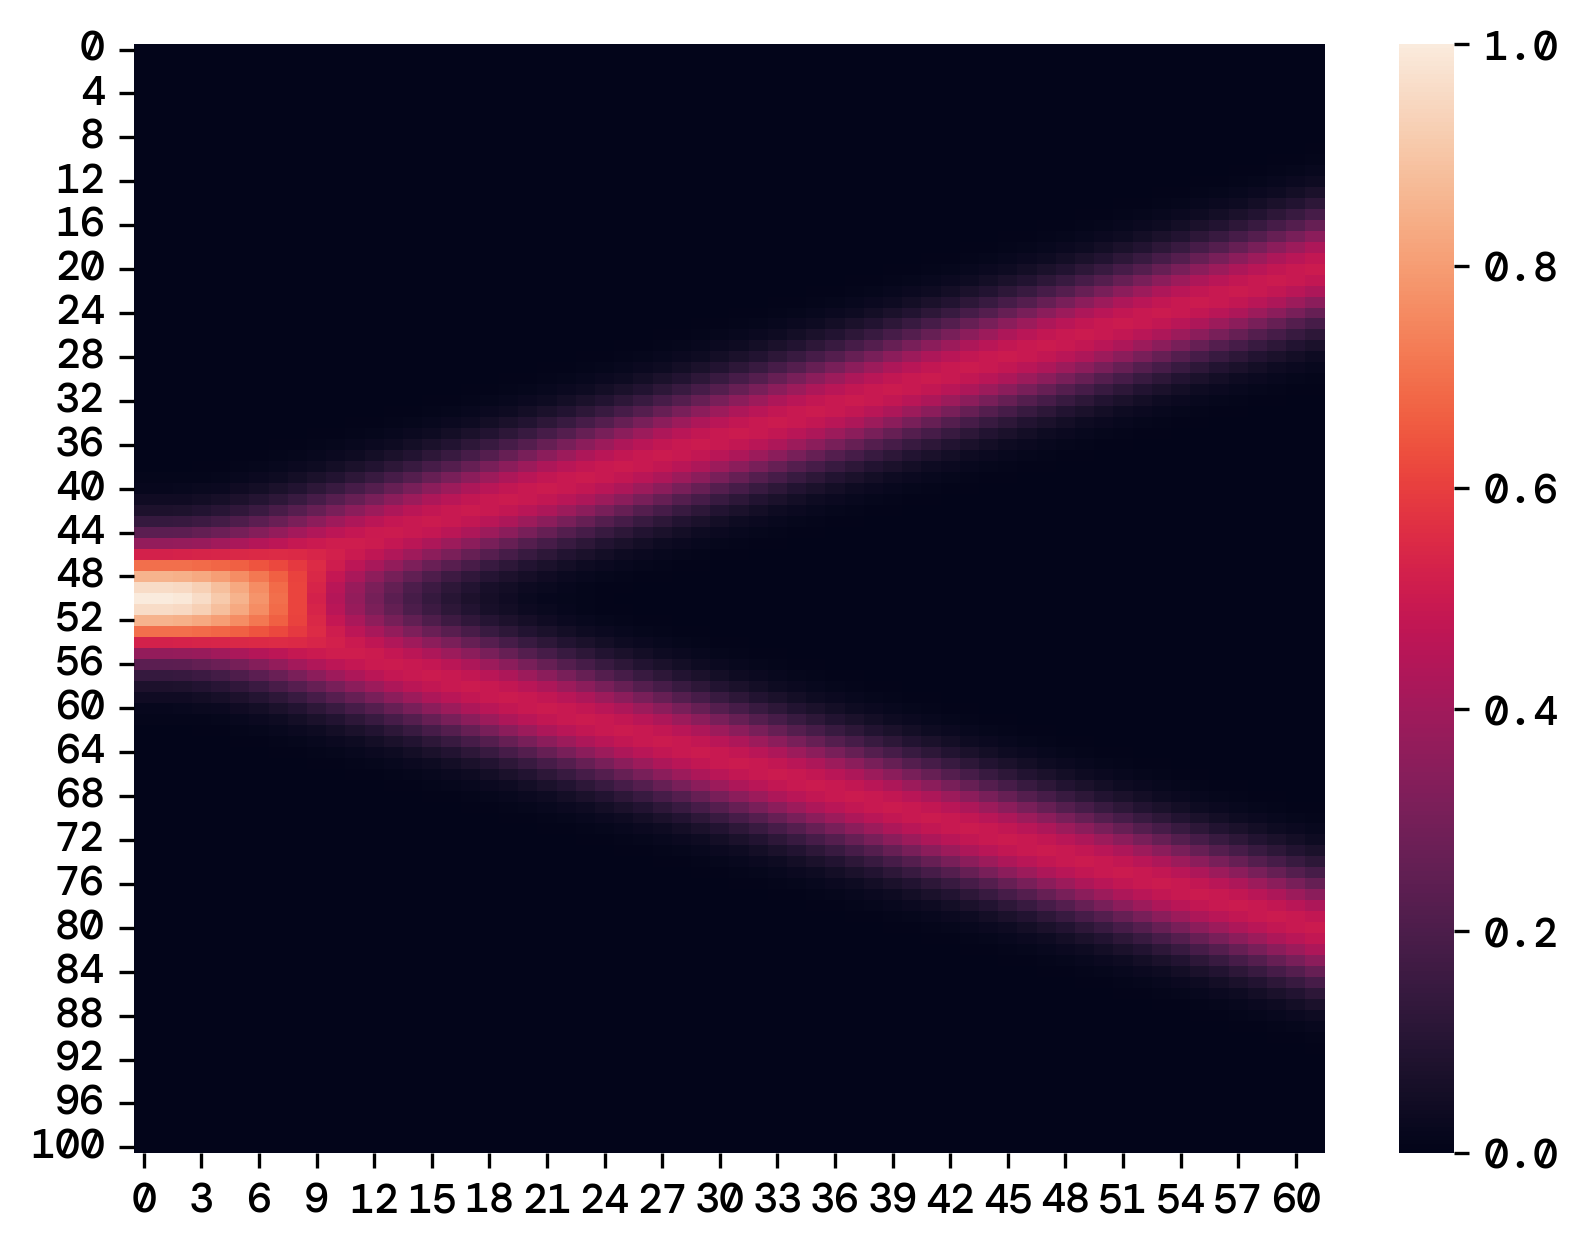

In [3]:
analytic = np.zeros((nt,nx)) # solution goes here
def analytic_sol(x, t):
    return 1/2 * (np.exp(-(x + c*t)**2 / 0.25) + np.exp(-(x - c*t)**2 / 0.25))


# set initial conditions
for a in range(0,nx):
    analytic[0,a]=init_fn(xmin+a*dx)
    analytic[1,a]=analytic[0,a]


# Simulate dynamics using the analytic solution
for t in range(1, nt-1):
    for a in range(1, nx-1):
        analytic[t+1, a] = analytic_sol(xmin + a * dx, t * dt)



# plot and animate
fig = plt.figure()
plts = []
for i in range(nt):
    p, = plt.plot(analytic[i,:], 'k')
    plts.append( [p] )
ani = animation.ArtistAnimation(fig, plts, interval=50, repeat_delay=500)
ani.save('wave_analytic.mp4')


sns.heatmap(analytic.T)
plt.savefig('../runsAndFigures/wave_analytic.png', bbox_inches='tight')
plt.show()

## Finite Difference Method

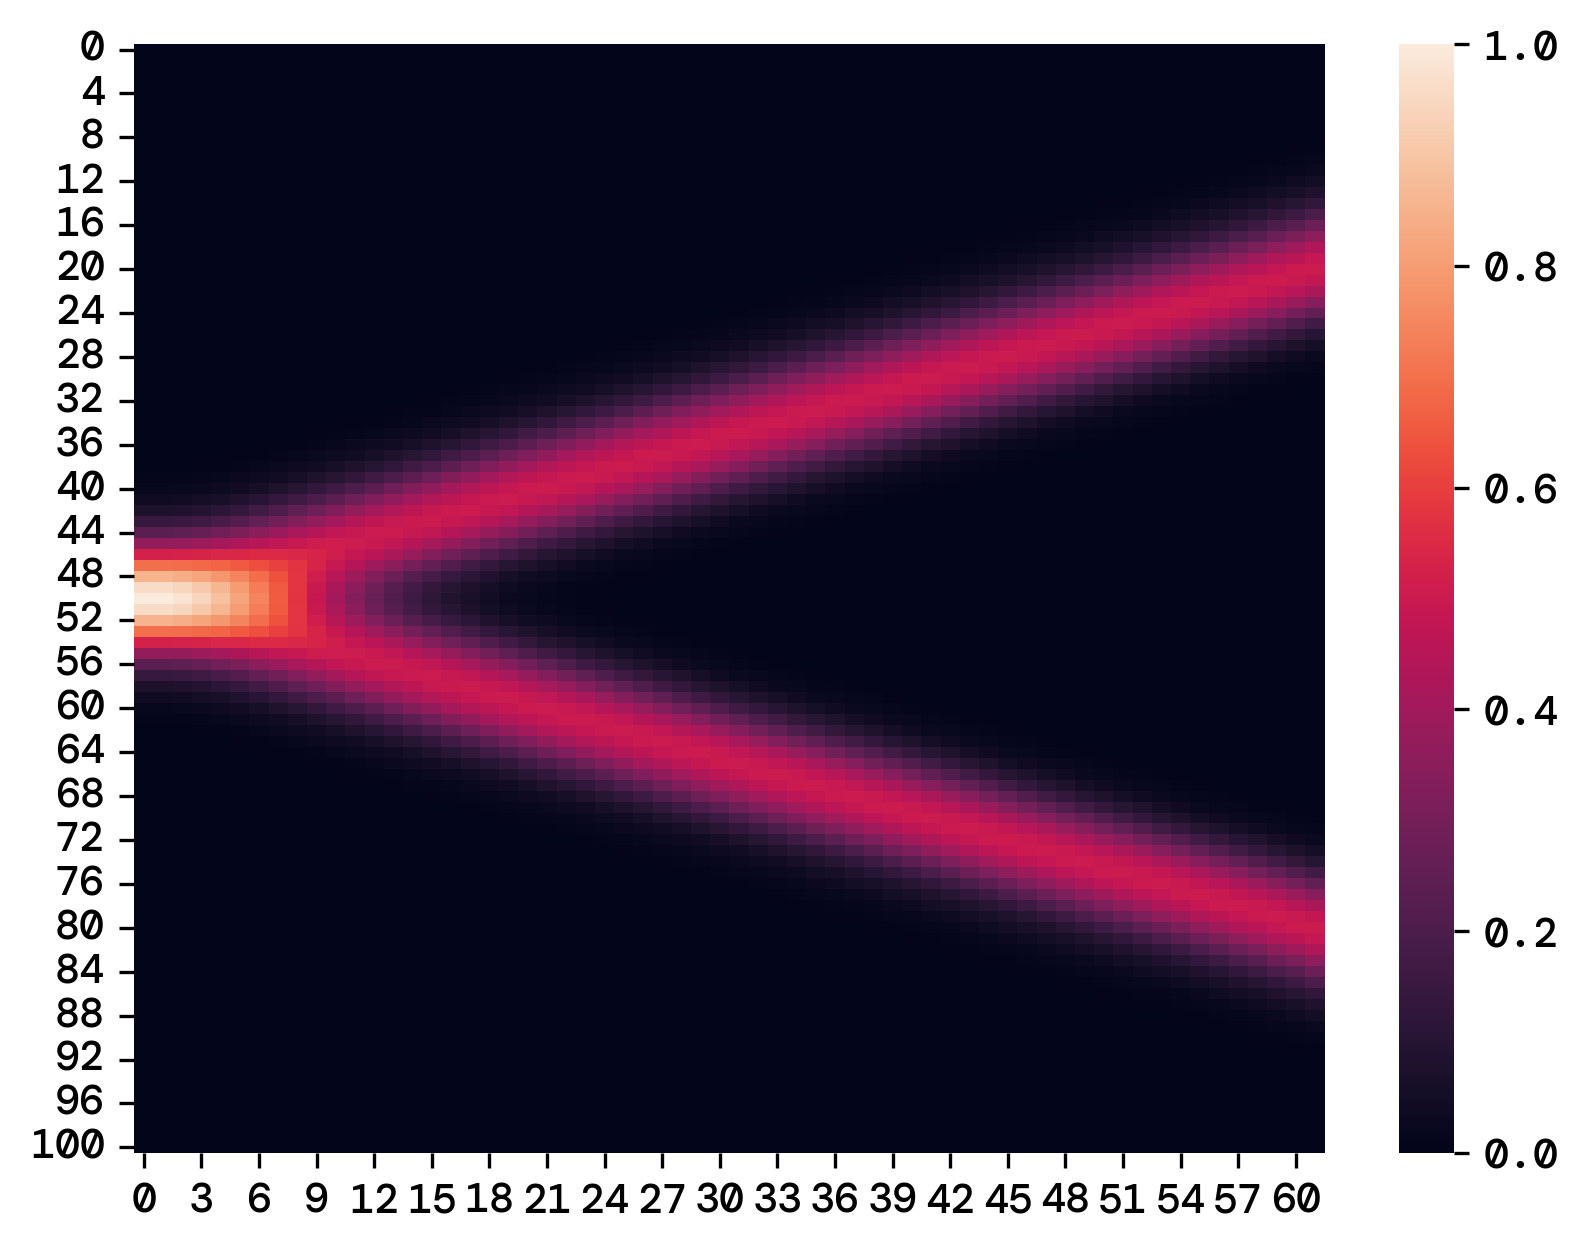

mean square difference between analytical and fintite solution: 4.9722476e-05


In [4]:
finite = np.zeros((nt,nx)) # solution goes here

for a in range(0,nx):
    finite[0,a]=init_fn(xmin+a*dx)
    finite[1,a]=finite[0,a]

#simulate dynamics
for t in range(1,nt-1):
    for a in range(1,nx-1):
        finite[t+1,a] = 2*(1-rsq)*finite[t,a]-finite[t-1,a]+rsq*(finite[t,a-1]+finite[t,a+1])


# plot and animate
fig = plt.figure()
plts = []
for i in range(nt):
    p, = plt.plot(finite[i,:], 'k')
    plts.append( [p] )
ani = animation.ArtistAnimation(fig, plts, interval=50, repeat_delay=500)
ani.save('wave_finite.mp4')




sns.heatmap(finite.T)
plt.savefig('../runsAndFigures/wave_finite.png', bbox_inches='tight')
plt.show()


# compare with analytic solution
score = ada.MSE(finite, analytic)
print("mean square difference between analytical and fintite solution:", score)

## NN Data and Preprocessing

In [5]:
x = np.linspace(xmin, xmax, nx)
t = np.linspace(tmin, tmax, nt)
X, T = np.meshgrid(x, t)
xt_mesh = np.vstack((X.flatten(), T.flatten())).T

## PINN with jax
#### Our own jax implementation

In [170]:
# hyperparameters
eta = 0.01
epochs = 8000
tol = 1e-6
alpha = 0.00001
gamma = 0.1
epsilon = 1e-8
beta1 = 0.9
beta2 = 0.999

batch_size = 1000

def generate_data_jax(batch_size):
    x = np.random.uniform(-1, 1, (batch_size, 1)).astype(np.float32)
    t = np.random.uniform(0, 2, (batch_size, 1)).astype(np.float32)
    return tf.convert_to_tensor(x), tf.convert_to_tensor(t)



def init_fn_jax(x):
    return jnp.exp(-(x**2)/0.25)


def h1(x, t):
    condition = (t == 0) | (t == dt)
    return jnp.where(condition, init_fn_jax(x), 0)



def trial_solution(y_pred, x, t):
    boundary_term = (x - xmin) * (xmax - x) * t * (t - dt)
    out = h1(x, t) + boundary_term * y_pred
    return out[0]



def second_derivative_t(y_pred, x, t):
    u_trial = lambda t: trial_solution(y_pred, x, t)
    return jax.grad(jax.grad(u_trial))(t)


def second_derivative_x(y_pred, x, t):
    u_trial = lambda x: trial_solution(y_pred, x, t)
    return jax.grad(jax.grad(u_trial))(x)



compute_second_derivative_t = jax.vmap(second_derivative_t)
compute_second_derivative_x = jax.vmap(second_derivative_x)

def loss_function(y_pred, t_dummy, X):
    x, t = X[:, 0], X[:, 1]
    u_tt_batch = compute_second_derivative_t(y_pred, x, t)
    u_xx_batch = compute_second_derivative_x(y_pred, x, t)
    residual_batch = u_tt_batch - c**2 * u_xx_batch
    mse = jnp.mean(residual_batch**2)    # Wave equation loss
    t_zero = tf.zeros_like(t)
    init_cond_loss_at_zero = tf.reduce_mean(tf.square(model(tf.concat([x, t_zero], axis=-1)) - init_fn(x)))

    # Calculate loss at t = dt
    t_dt = t_zero + dt
    init_cond_loss_at_dt = tf.reduce_mean(tf.square(model(tf.concat([x, t_dt], axis=-1)) - init_fn(x)))

    # this ensures that the initial condition is satisfied at t = 0 and t = dt
    # with only t=0, we allow the network to find solutions with arbitrary initial velocity
    # this is essentially the h2 function in the paper
    total_init_cond_loss = (init_cond_loss_at_zero + init_cond_loss_at_dt) / 2

    # the PDE to sovle is u_tt = c^2 * u_xx | the wave equation
    # we want the left hand side to be equal to zero
    wave_eq_loss = tf.reduce_mean((u_tt - c**2 * u_xx)**2)
    return wave_eq_loss + total_init_cond_loss



network = ada.NN.Model([[50,sigmoid],[60,sigmoid],[10,sigmoid], [1, eye]], eta,epochs,tol, 'adam', alpha, gamma, epsilon, beta1, beta2, loss=loss_function, metric=loss_function)
loss, _ = network.fit(data, t_dummy)

Training stopped after 7999 epochs                                    

0.047273673
MSE of NN method: 0.03496165


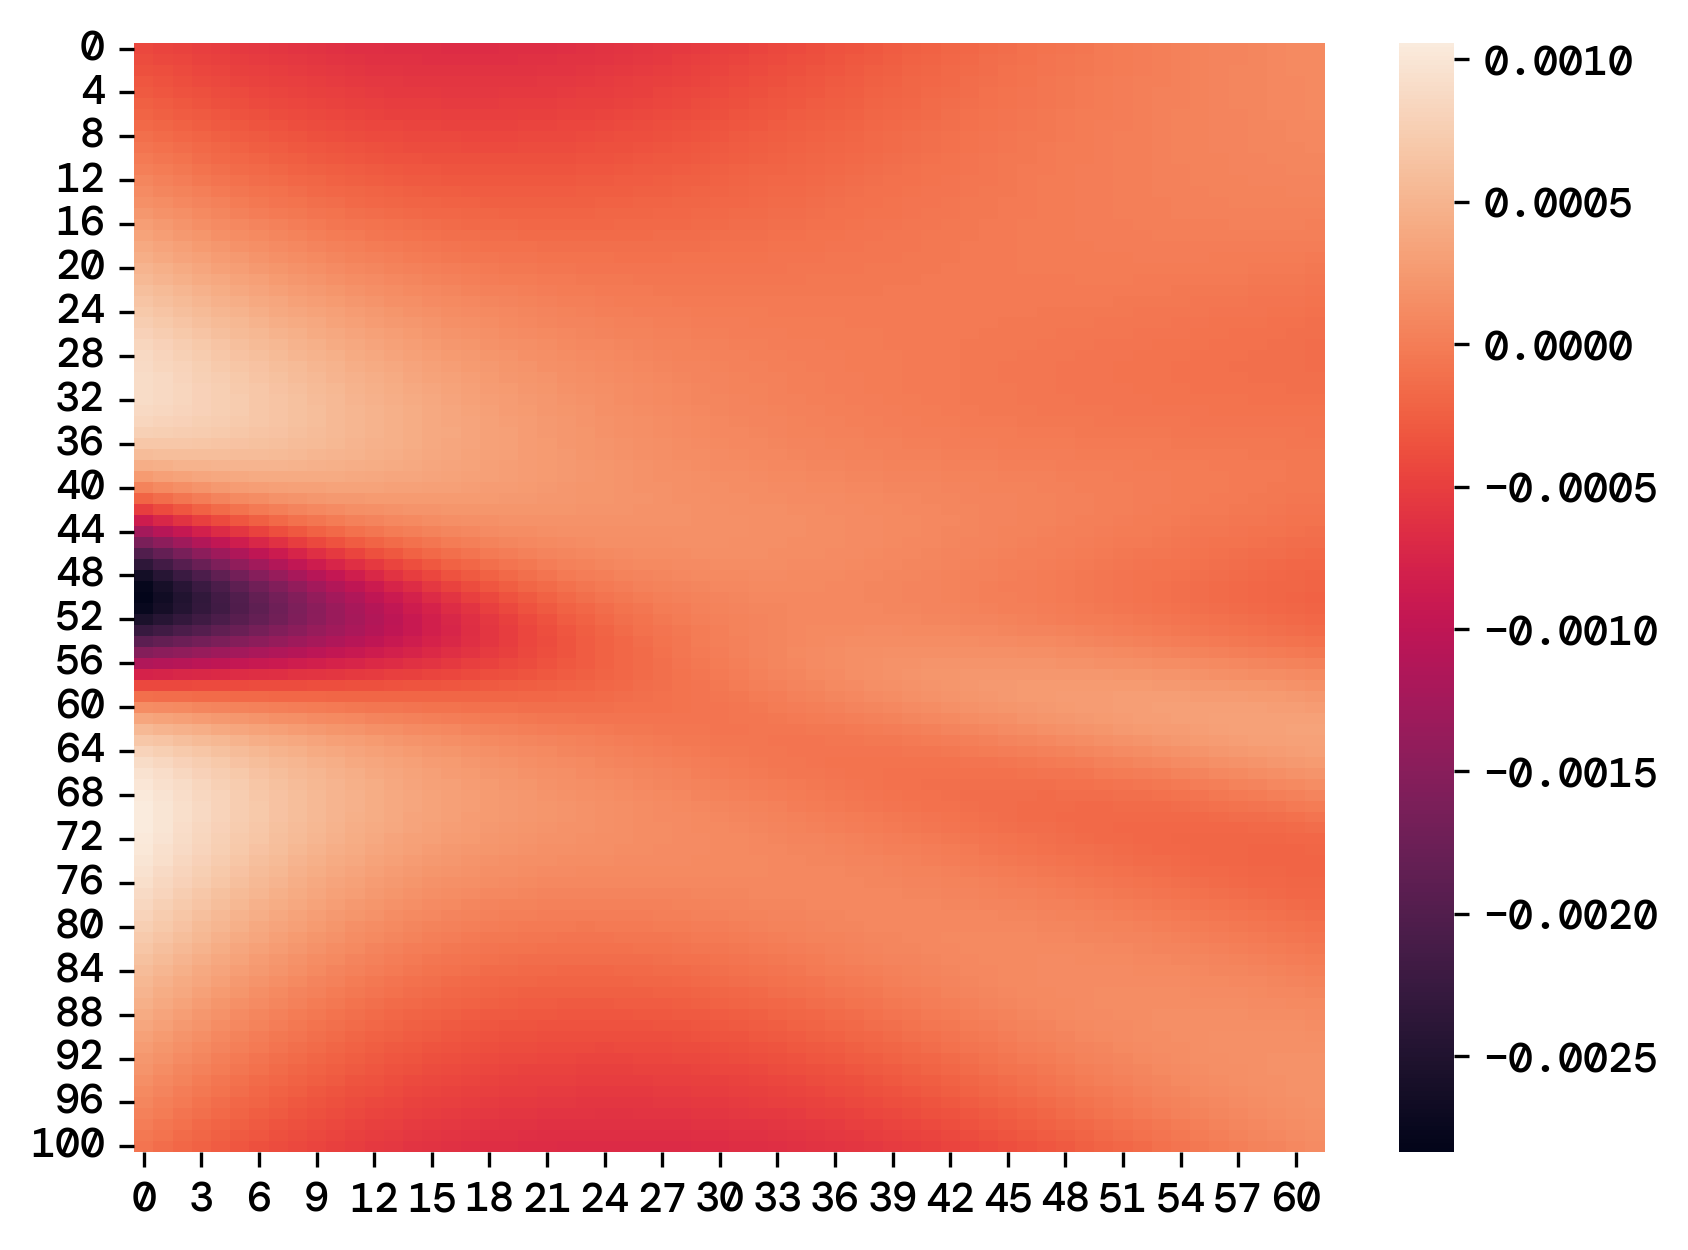

In [171]:
nn_result = network.predict(xt_mesh)

fig = plt.figure()
plts = []
for i in range(nt):
    p, = plt.plot(nn_result[i,:], 'k')
    plts.append( [p] )
ani = animation.ArtistAnimation(fig, plts, interval=50, repeat_delay=500)
ani.save('wave_own_dnn.mp4')


print(loss_function(nn_result, xt_mesh[:,0] , xt_mesh))
nn_result = nn_result.reshape((nt, nx))
score = ada.MSE(nn_result, analytic)
print("MSE of NN method:", score)

sns.heatmap(nn_result.T)
plt.savefig('../runsAndFigures/wave_own_dnn.png', bbox_inches='tight')
plt.show()



Our first attempt to solve the PDE is to use a dense neural network. Our own model struggles quite a bit, we don't have access to the inner workings of the model. It is bulit primarily to solve more classical machine learning problems. When we try to solve a PDE, we need to be able to use special loss functions and optimizers.

## Physics Informed Neural Network (PINN) with Tensorflow

In [6]:


# Define constants
num_epochs = 5000
batch_size = 1000

# Neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(50, activation='tanh', input_shape=(2,)),
    tf.keras.layers.Dense(50, activation='tanh'),
    # tf.keras.layers.Dense(50, activation='tanh'),
    tf.keras.layers.Dense(1)
])

# Initial condition function
def init_fn(x):
    return np.exp(-(x**2) / 0.25)

# Loss function
def loss_fn(x, t):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x, t])
        X = tf.stack([x[:, 0], t[:, 0]], axis=1)
        u = model(X)
        u_x = tape.gradient(u, x)
        u_t = tape.gradient(u, t)
        u_xx = tape.gradient(u_x, x)
        u_tt = tape.gradient(u_t, t)

    t_zero = tf.zeros_like(t)
    init_cond_loss_at_zero = tf.reduce_mean(tf.square(model(tf.concat([x, t_zero], axis=-1)) - init_fn(x)))

    # Calculate loss at t = dt
    t_dt = t_zero + dt
    init_cond_loss_at_dt = tf.reduce_mean(tf.square(model(tf.concat([x, t_dt], axis=-1)) - init_fn(x)))

    # this ensures that the initial condition is satisfied at t = 0 and t = dt
    # with only t=0, we allow the network to find solutions with arbitrary initial velocity
    # this is essentially the h2 function in the paper
    total_init_cond_loss = (init_cond_loss_at_zero + init_cond_loss_at_dt) / 2

    # the PDE to sovle is u_tt = c^2 * u_xx | the wave equation
    # we want the left hand side to be equal to zero
    wave_eq_loss = tf.reduce_mean((u_tt - c**2 * u_xx)**2)
    return wave_eq_loss + total_init_cond_loss


# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, weight_decay=0.0001)
history = []
# Training step
def train_step(x, t):
    with tf.GradientTape() as tape:
        loss = loss_fn(x, t)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    history.append(loss.numpy())
    return loss


def generate_data(batch_size):
    x = np.random.uniform(-5, 5, (batch_size, 1)).astype(np.float32)
    t = np.random.uniform(0, 3, (batch_size, 1)).astype(np.float32)
    return tf.convert_to_tensor(x), tf.convert_to_tensor(t)


# Training loop
for epoch in range(num_epochs):
    x_out, t_out = generate_data(batch_size)
    loss = train_step(x_out, t_out)
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.numpy()}')




Epoch 0, Loss: 0.2727290093898773
Epoch 100, Loss: 0.037319332361221313
Epoch 200, Loss: 0.028161823749542236
Epoch 300, Loss: 0.024907156825065613
Epoch 400, Loss: 0.016068032011389732
Epoch 500, Loss: 0.009440679103136063
Epoch 600, Loss: 0.006851223763078451
Epoch 700, Loss: 0.005331429652869701
Epoch 800, Loss: 0.003595657180994749
Epoch 900, Loss: 0.0026209503412246704
Epoch 1000, Loss: 0.001606672303751111
Epoch 1100, Loss: 0.001389369135722518
Epoch 1200, Loss: 0.0009868151973932981
Epoch 1300, Loss: 0.0007473103469237685
Epoch 1400, Loss: 0.000565411988645792
Epoch 1500, Loss: 0.0004502655647229403
Epoch 1600, Loss: 0.00038161128759384155
Epoch 1700, Loss: 0.0002959597040899098
Epoch 1800, Loss: 0.00026836598408408463
Epoch 1900, Loss: 0.0002190937811974436
Epoch 2000, Loss: 0.00021446299797389656
Epoch 2100, Loss: 0.00017108953034039587
Epoch 2200, Loss: 0.00016370019875466824
Epoch 2300, Loss: 0.00016792112728580832
Epoch 2400, Loss: 0.00013530846626963466
Epoch 2500, Loss: 0

196/196 [==============================] - 1s 3ms/step
MSE difference between analytical and NN solution: 0.0126148835


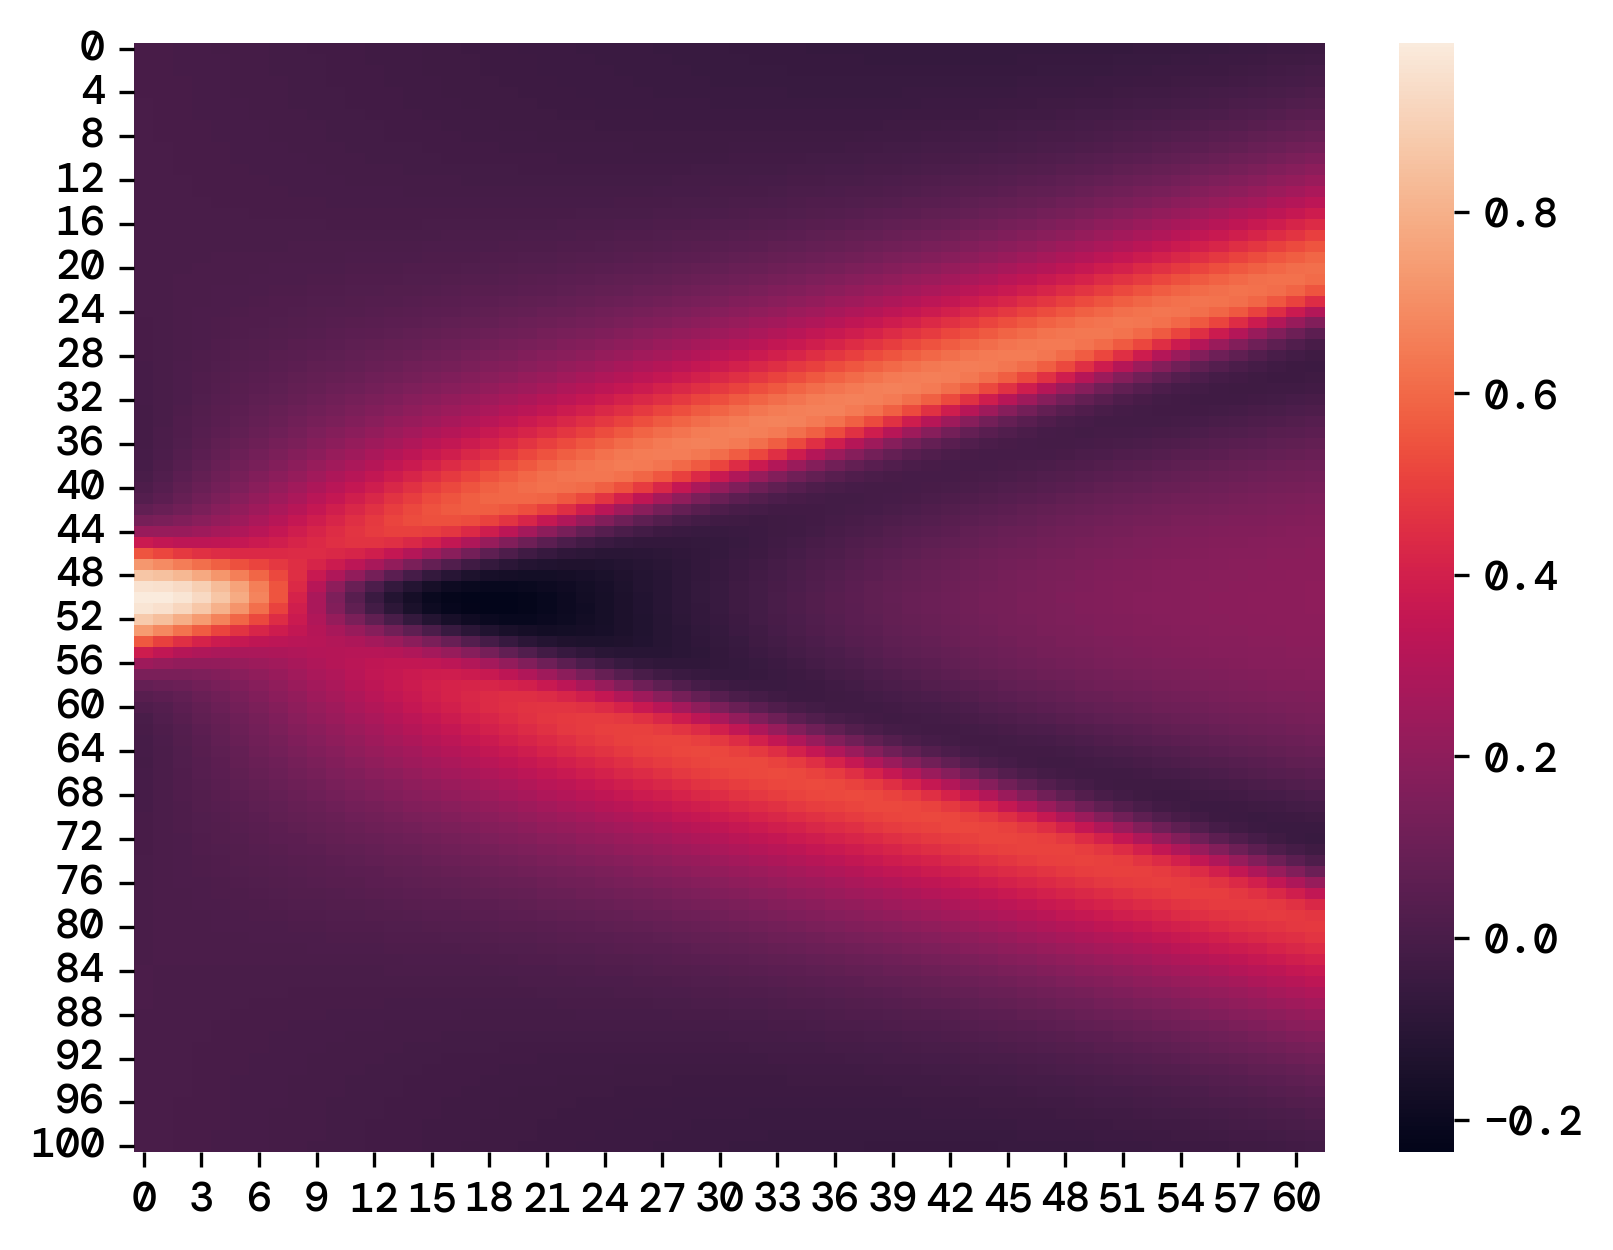

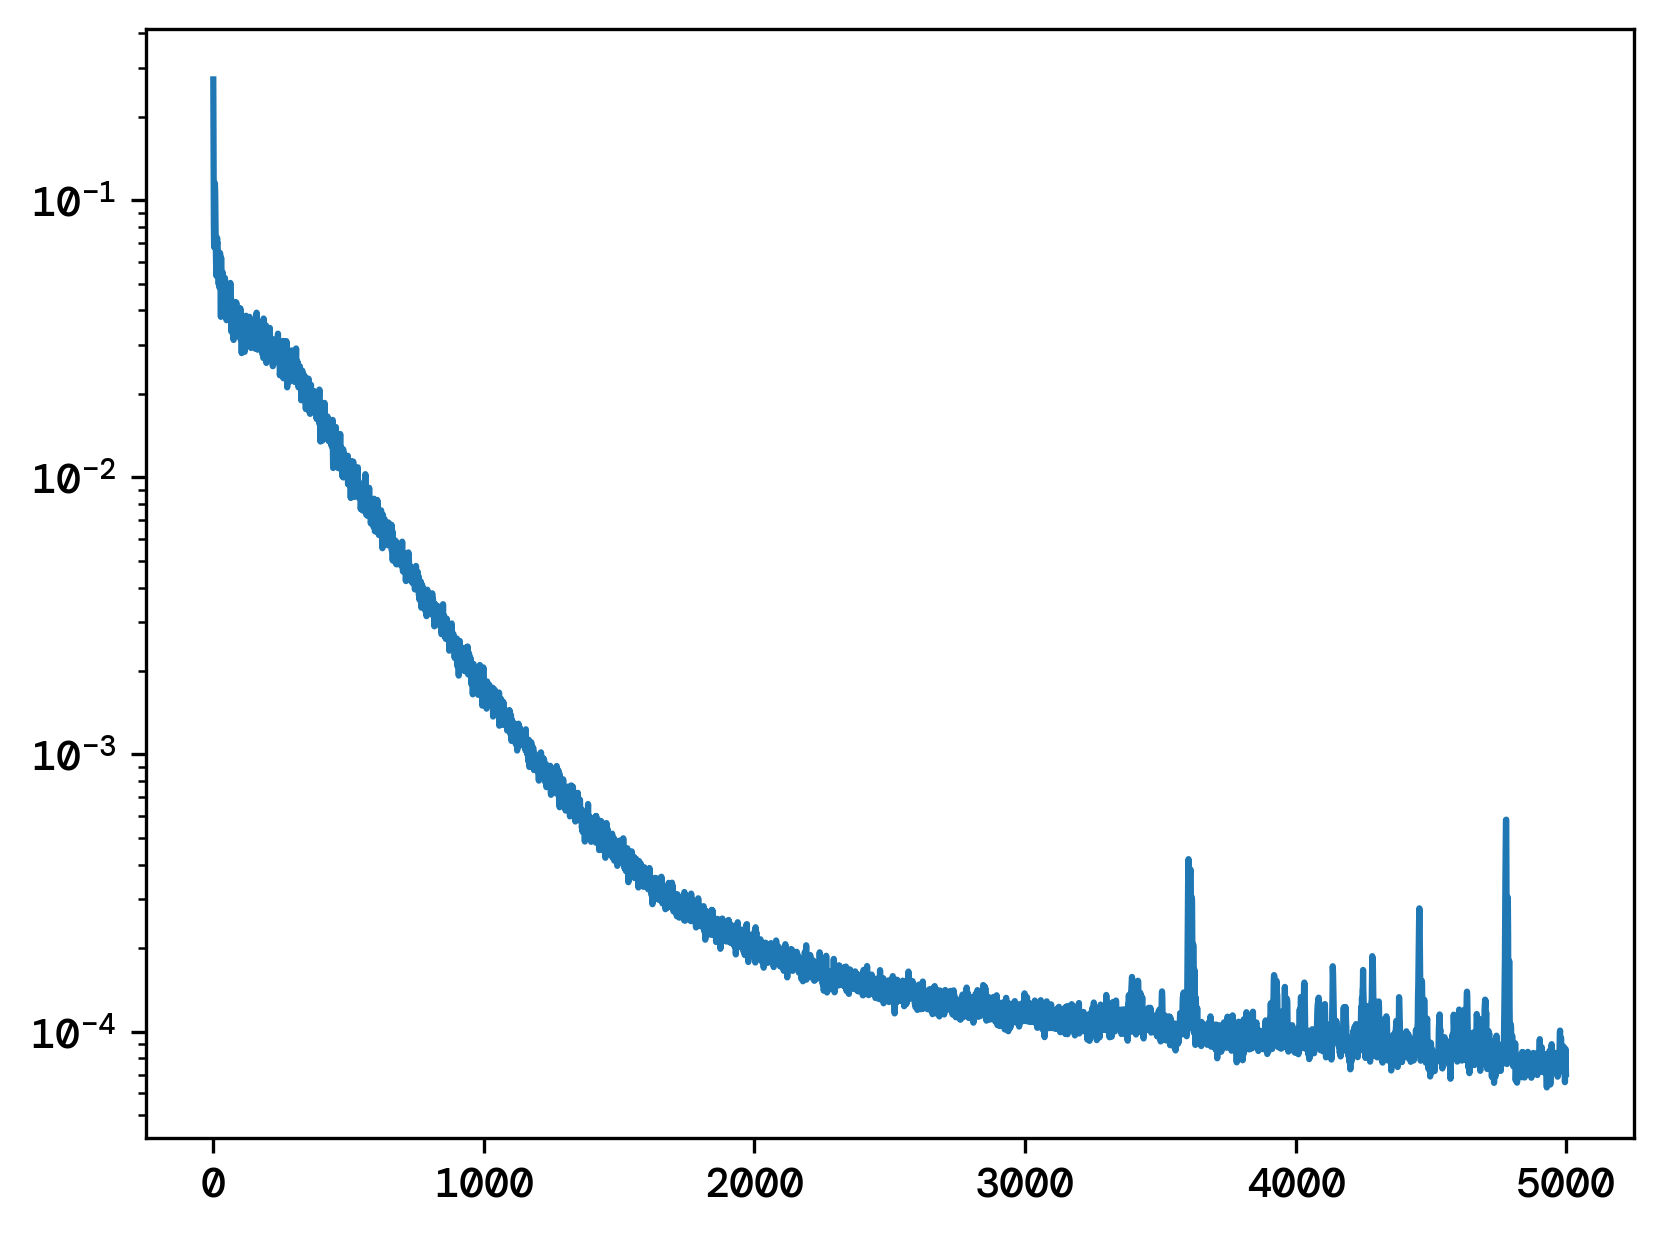

In [7]:


# Predict u(x, t) on the grid
u_pred = model.predict(xt_mesh)
u_pred = u_pred.reshape((nt, nx))

score = ada.MSE(u_pred, analytic)
print("MSE difference between analytical and NN solution:", score)
# Plotting the heatmap

fig = plt.figure()
plts = []
for i in range(nt):
    p, = plt.plot(u_pred[i,:], 'k')
    plts.append( [p] )
ani = animation.ArtistAnimation(fig, plts, interval=50, repeat_delay=500)
ani.save('wave_tf_pinn.mp4')

sns.heatmap(u_pred.T)
plt.savefig('../runsAndFigures/wave_tf_pinn.png', bbox_inches='tight')
plt.show()

# Plotting the loss
plt.plot(history)
plt.yscale('log')
plt.savefig('../runsAndFigures/wave_tf_pinn_loss.png', bbox_inches='tight')


# t_large = np.linspace(0, 10, 100)
# X, T = np.meshgrid(x, t_large)
# xt_mesh_large = np.vstack((X.flatten(), T.flatten())).T
# u_pred = model.predict(xt_mesh_large)
# u_pred = u_pred.reshape((100, nx))
# sns.heatmap(u_pred.T)
# plt.savefig('../runsAndFigures/wave_tf_pinn_long.png', bbox_inches='tight')
# plt.show()



## Hybrid Solver
Combining the finite difference method with a neural network. We use the finite difference method to generate data for the neural network. The neural network is then trained on this data. In addition to this supervised learning, we aslo use a unsupervised physics informed learning. This is done by adding the PDE as a loss function like the thechnique used above

In [40]:

# Define constants
num_epochs = 5000
batch_size = 1000

# Neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(50, activation='tanh', input_shape=(2,)),
    tf.keras.layers.Dense(50, activation='tanh'),
    # tf.keras.layers.Dense(50, activation='tanh'),
    tf.keras.layers.Dense(1)
])

# Initial condition function
def init_fn(x):
    return np.exp(-(x**2) / 0.25)

# Loss function
def loss_fn(x, t, target, epoch):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x, t])
        X = tf.stack([x[:, 0], t[:, 0]], axis=1)
        u = model(X)
        u_x = tape.gradient(u, x)
        u_t = tape.gradient(u, t)
        u_xx = tape.gradient(u_x, x)
        u_tt = tape.gradient(u_t, t)

    data_loss = tf.reduce_mean(tf.square(u - target ))
    # Wave equation loss
    t_zero = tf.zeros_like(t)
    init_cond_loss_at_zero = tf.reduce_mean(tf.square(model(tf.concat([x, t_zero], axis=-1)) - init_fn(x)))

    t_dt = t_zero + dt
    init_cond_loss_at_dt = tf.reduce_mean(tf.square(model(tf.concat([x, t_dt], axis=-1)) - init_fn(x)))

    total_init_cond_loss = (init_cond_loss_at_zero + init_cond_loss_at_dt) / 2

    wave_eq_loss = tf.reduce_mean((u_tt - c**2 * u_xx)**2)
    # return wave_eq_loss + total_init_cond_loss + data_loss #/ (epoch + 1)
    return wave_eq_loss + data_loss #/ (epoch + 1)


# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, weight_decay=0.0001)
history = []

# Training step
def train_step(x, t, targets, epoch):
    with tf.GradientTape() as tape:
        loss = loss_fn(x, t, targets, epoch)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    history.append(loss.numpy())
    return loss


def generate_data(batch_size, x, t):
    x_indicies = np.random.randint(0, nx, batch_size)
    t_indicies = np.random.randint(0, nt, batch_size)
    targets = finite[t_indicies, x_indicies].reshape((-1, 1)).astype(np.float32)
    x_out = x[x_indicies].reshape((-1, 1)).astype(np.float32)
    t_out = t[t_indicies].reshape((-1, 1)).astype(np.float32)
    return tf.convert_to_tensor(x_out), tf.convert_to_tensor(t_out), tf.convert_to_tensor(targets)


# Training loop
for epoch in range(num_epochs):
    x_out, t_out, y = generate_data(batch_size, x, t)
    loss = train_step(x_out, t_out, y, epoch)
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.numpy()}')

Epoch 0, Loss: 0.07390837371349335
Epoch 100, Loss: 0.02191135659813881
Epoch 200, Loss: 0.016431717202067375
Epoch 300, Loss: 0.012478544376790524
Epoch 400, Loss: 0.008273081853985786
Epoch 500, Loss: 0.006998111959546804
Epoch 600, Loss: 0.0036381769459694624
Epoch 700, Loss: 0.002200491027906537
Epoch 800, Loss: 0.0013913280563428998
Epoch 900, Loss: 0.0008167077321559191
Epoch 1000, Loss: 0.0004806656506843865
Epoch 1100, Loss: 0.0003636579785961658
Epoch 1200, Loss: 0.00026211998192593455
Epoch 1300, Loss: 0.00018957842257805169
Epoch 1400, Loss: 0.00014759236364625394
Epoch 1500, Loss: 0.00011303356586722657
Epoch 1600, Loss: 9.599511395208538e-05
Epoch 1700, Loss: 8.813494787318632e-05
Epoch 1800, Loss: 8.379347127629444e-05
Epoch 1900, Loss: 6.990831025177613e-05
Epoch 2000, Loss: 8.31133293104358e-05
Epoch 2100, Loss: 5.389032230596058e-05
Epoch 2200, Loss: 7.927844126243144e-05
Epoch 2300, Loss: 7.325362821575254e-05
Epoch 2400, Loss: 6.381780258379877e-05
Epoch 2500, Loss: 

196/196 [==============================] - 1s 3ms/step
MSE of hybrid method: 0.00011668598


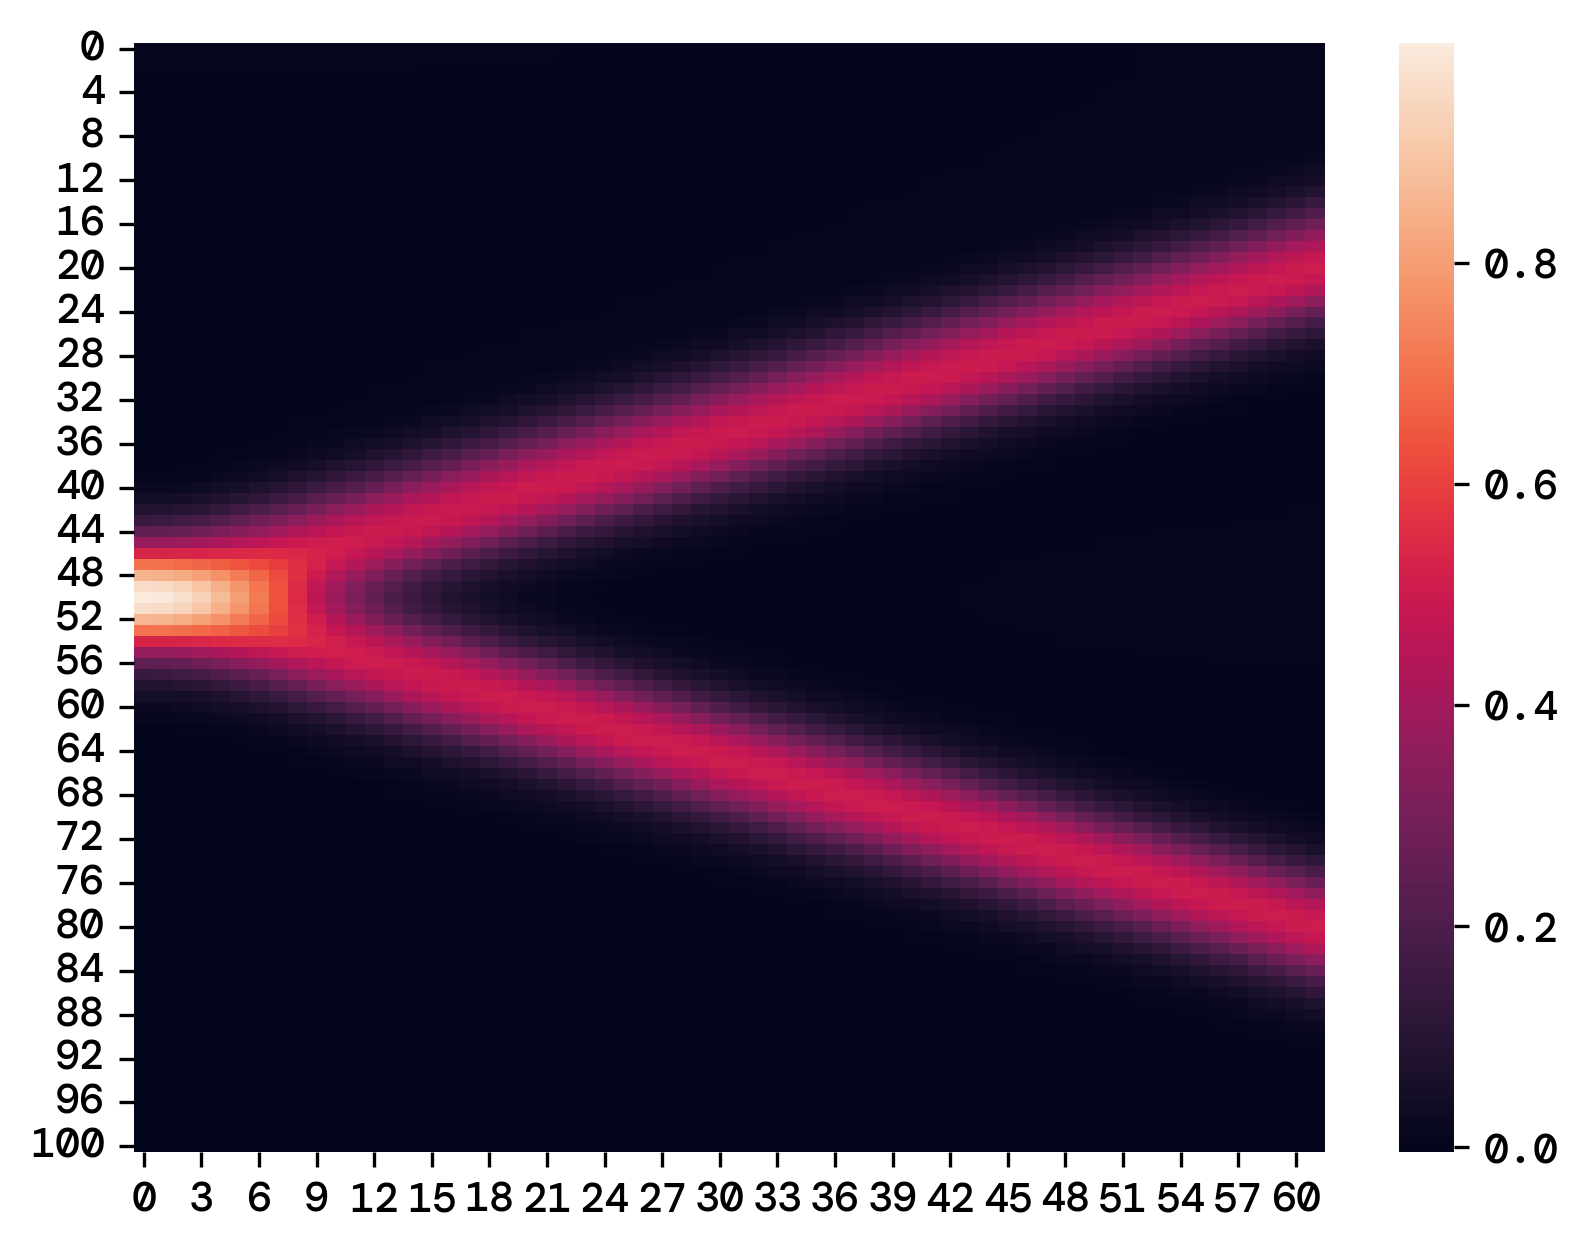

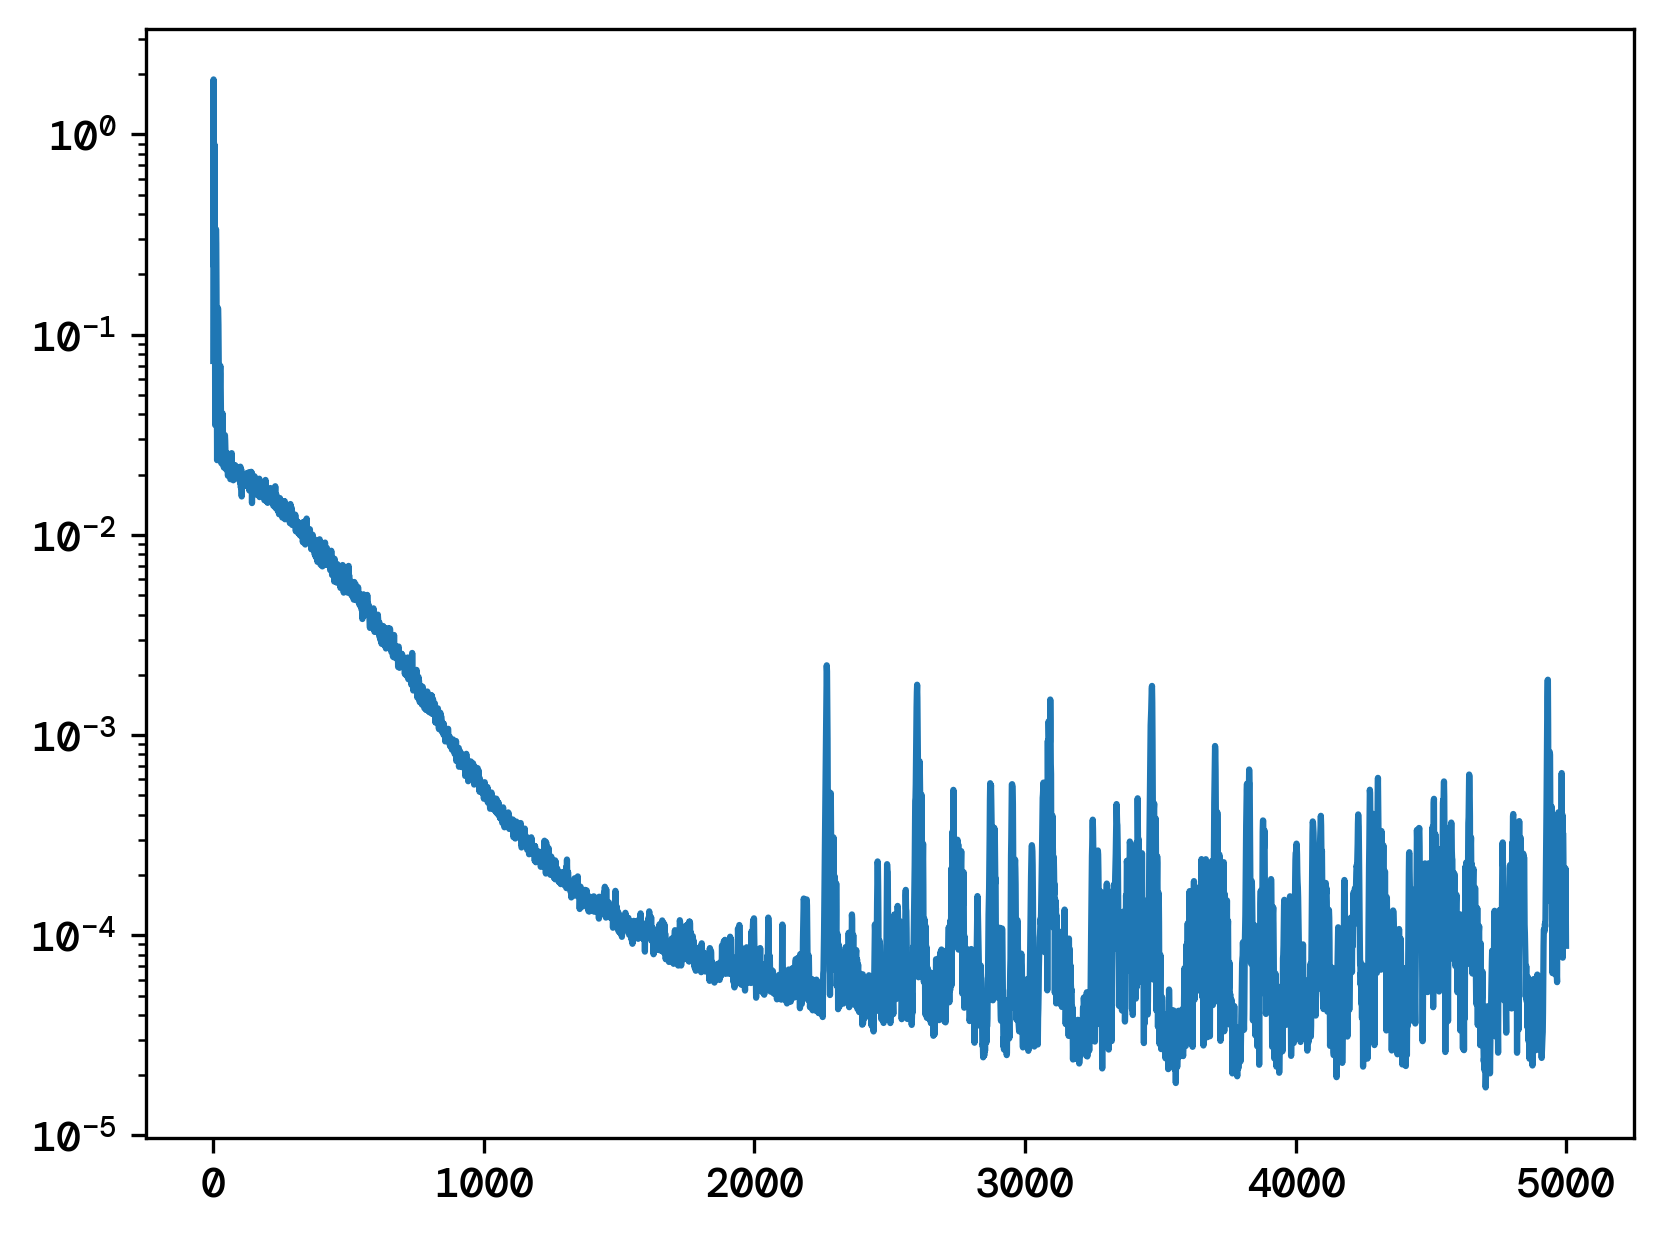

In [41]:
# Predict u(x, t) on the grid
u_pred = model.predict(xt_mesh)
u_pred = u_pred.reshape((nt, nx))

# Plotting the heatmap
score = ada.MSE(u_pred, analytic)
print("MSE of hybrid method:", score)


fig = plt.figure()
plts = []
for i in range(nt):
    p, = plt.plot(u_pred[i,:], 'k')
    plts.append( [p] )
ani = animation.ArtistAnimation(fig, plts, interval=50, repeat_delay=500)
ani.save('wave_tf_hybrid.mp4')

sns.heatmap(u_pred.T)
plt.savefig('../runsAndFigures/wave_tf_hybrid.png', bbox_inches='tight')
plt.show()


# Plotting the loss
plt.plot(history)
plt.yscale('log')
plt.savefig('../runsAndFigures/wave_tf_hybrid_loss.png', bbox_inches='tight')

## Recurrent Neural Network (RNN)
Different task than PINN and FDM. We are trying to learn the dynamics from the data. We are not trying to learn the solution of the PDE.
with a recurrent neural network we can learn the dynamics of the system. We can then use this to predict the future of the system. Or predict systems with different initial conditions.

In [11]:
def create_rnn_dataset(data, sequence_length):
    inputs, targets = [], []
    for i in range(len(data) - sequence_length):
        inputs.append(data[i:i + sequence_length])
        targets.append(data[i + sequence_length])
    return np.array(inputs), np.array(targets)

sequence_length = 10 
rnn_inputs, rnn_targets = create_rnn_dataset(analytic, sequence_length)

print(rnn_inputs.shape)
print(rnn_targets.shape)

# Split into training and testing sets
train_size = int(0.8 * len(rnn_inputs))
train_inputs, train_targets = rnn_inputs[:train_size], rnn_targets[:train_size]
test_inputs, test_targets = rnn_inputs[train_size:], rnn_targets[train_size:]




model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(sequence_length, nx)),
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dense(nx)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(train_inputs, train_targets, epochs=500, validation_data=(test_inputs, test_targets))



1.0
[1.         1.         0.99004983 0.96078944 0.91393119 0.85214379
 0.77880078 0.69767633 0.61262639 0.52729242]
(52, 10, 101)
(52, 101)
Epoch 1/500
2/2 [==============================] - 3s 595ms/step - loss: 0.0357 - val_loss: 0.0324
Epoch 2/500
2/2 [==============================] - 0s 64ms/step - loss: 0.0304 - val_loss: 0.0309
Epoch 3/500
2/2 [==============================] - 0s 76ms/step - loss: 0.0271 - val_loss: 0.0299
Epoch 4/500
2/2 [==============================] - 0s 65ms/step - loss: 0.0246 - val_loss: 0.0289
Epoch 5/500
2/2 [==============================] - 0s 66ms/step - loss: 0.0224 - val_loss: 0.0281
Epoch 6/500
2/2 [==============================] - 0s 70ms/step - loss: 0.0204 - val_loss: 0.0273
Epoch 7/500
2/2 [==============================] - 0s 73ms/step - loss: 0.0183 - val_loss: 0.0265
Epoch 8/500
2/2 [==============================] - 0s 69ms/step - loss: 0.0163 - val_loss: 0.0258
Epoch 9/500
2/2 [==============================] - 0s 62ms/step - loss: 0.

2/2 [==============================] - 0s 7ms/step


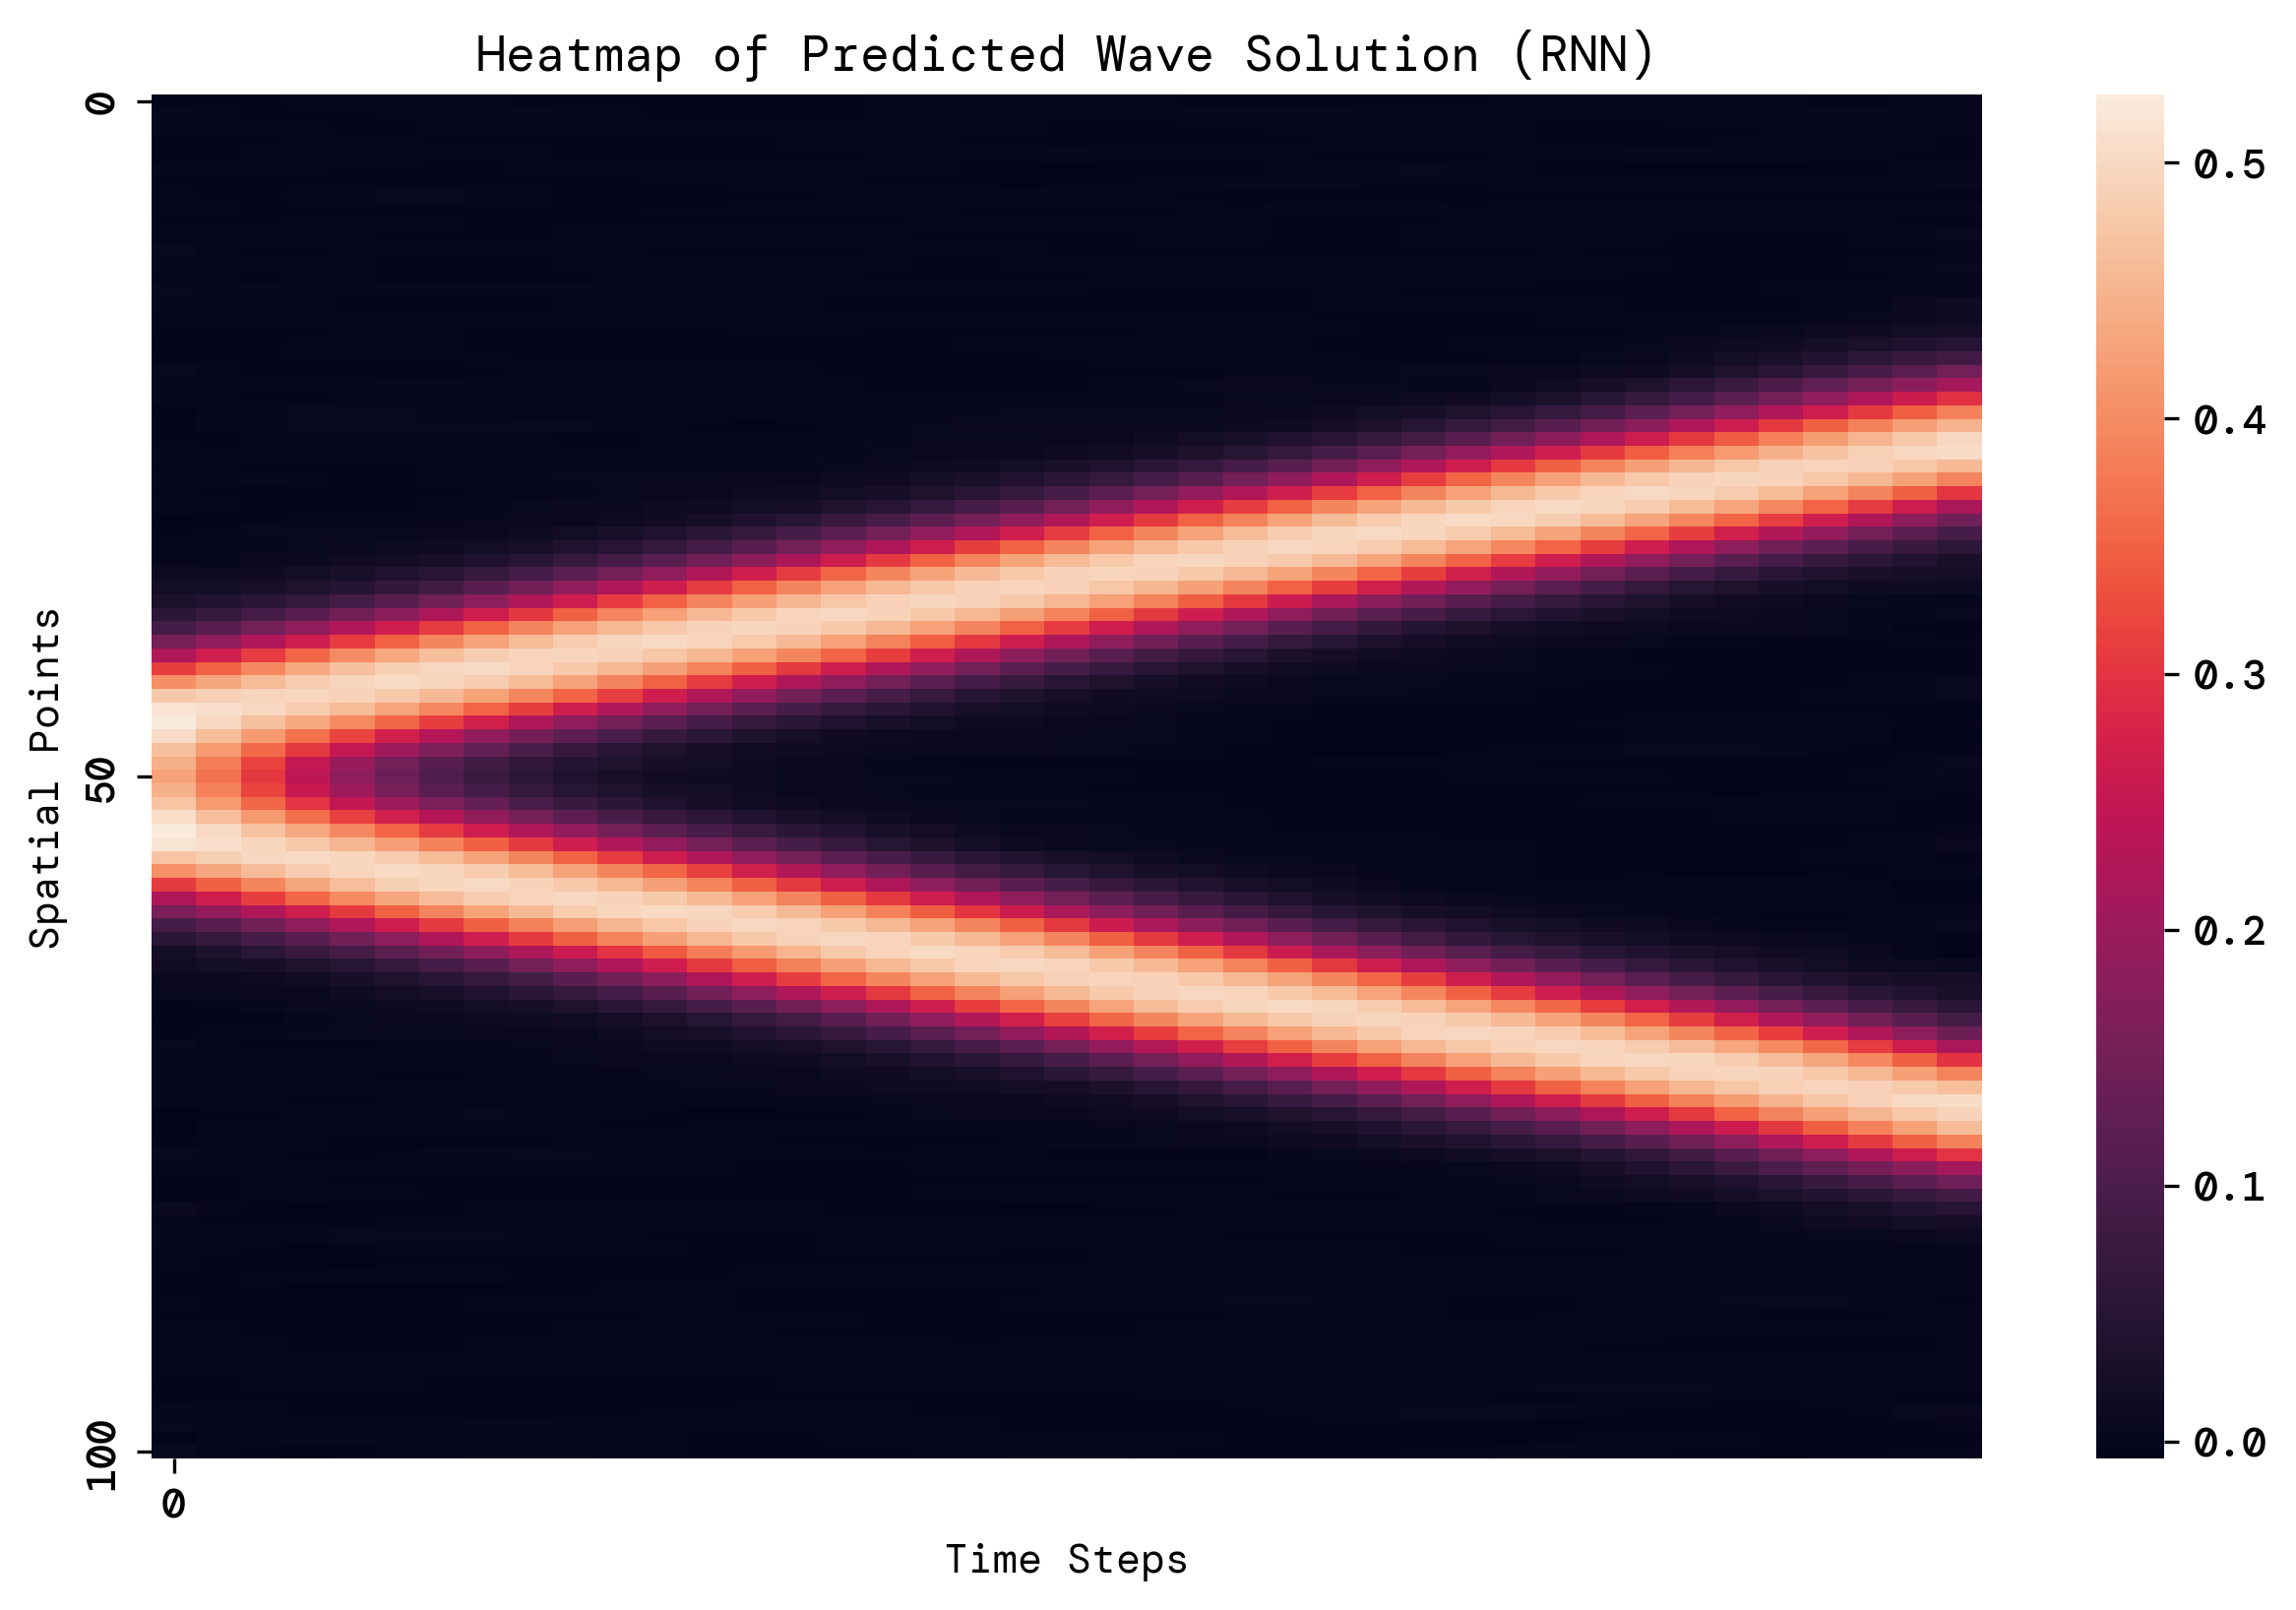

1/1 [==============================] - 0s 38ms/step


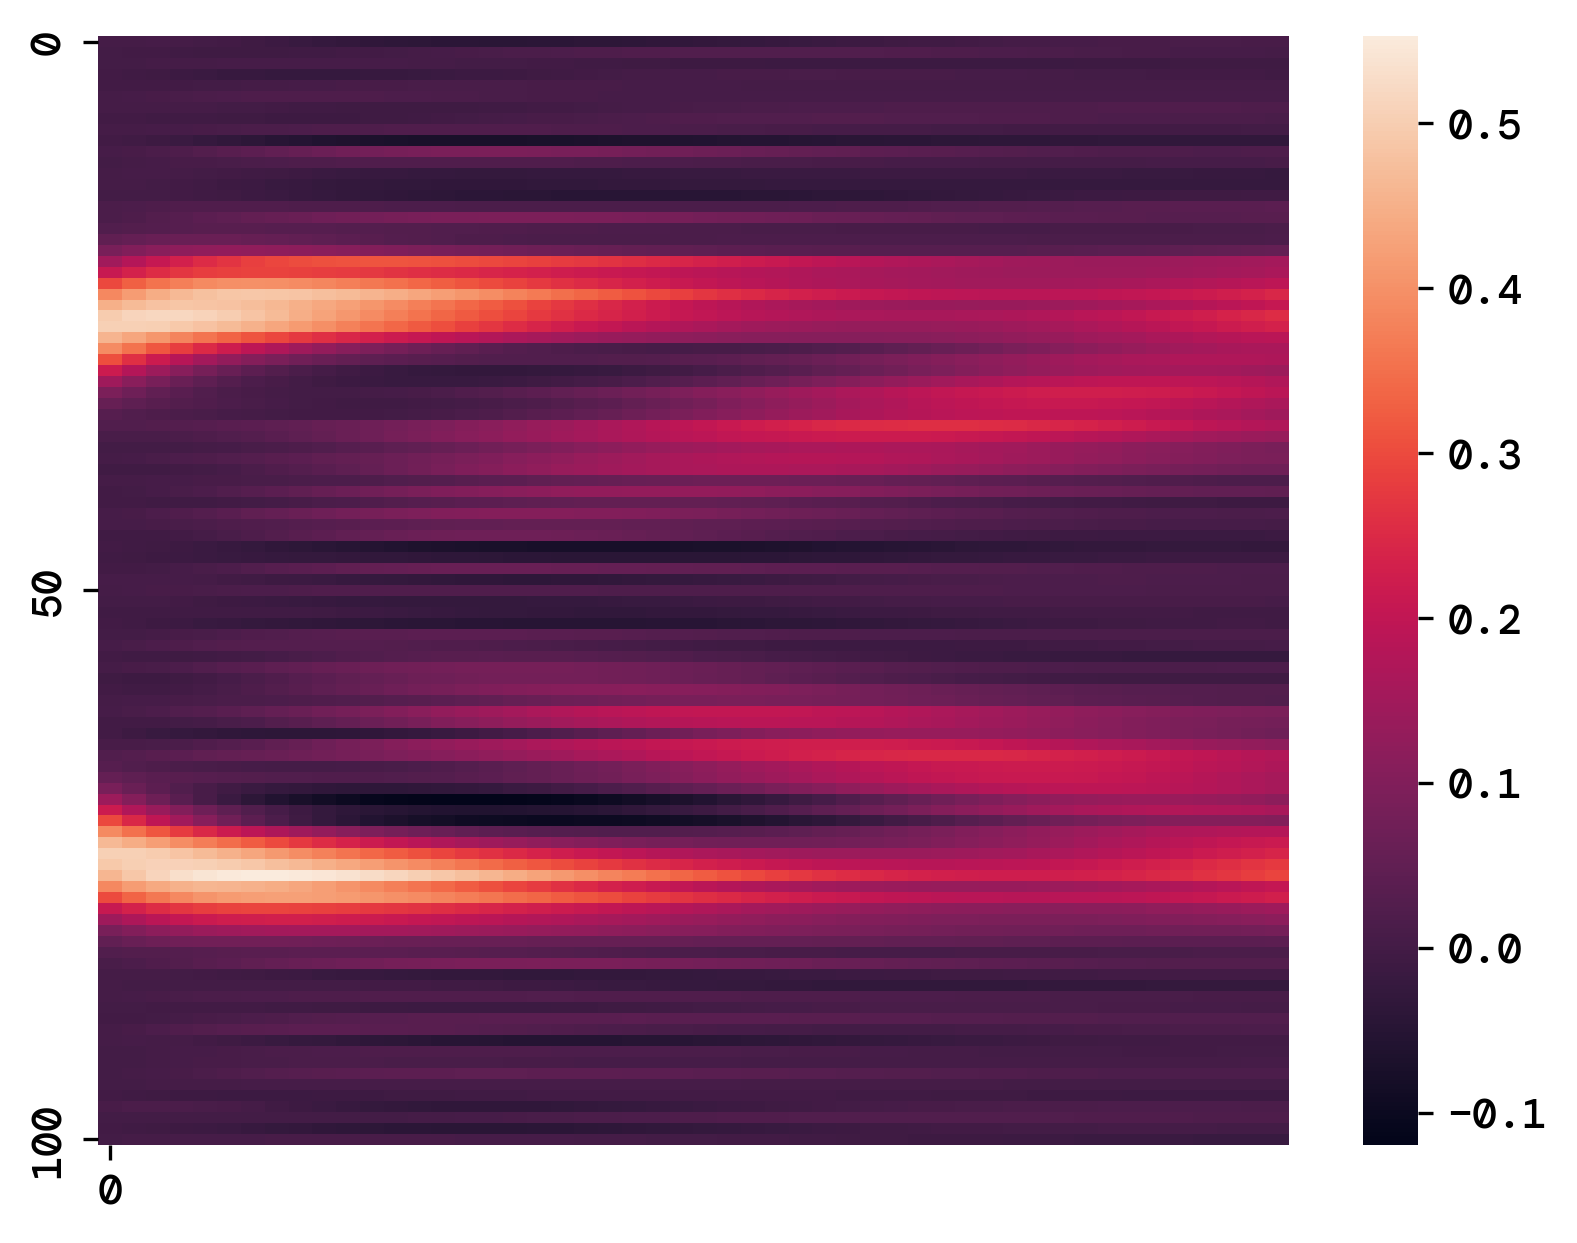

In [12]:


u_pred = model.predict(train_inputs)

# Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(u_pred.T, xticklabels=50, yticklabels=50)
plt.xlabel('Time Steps')
plt.ylabel('Spatial Points')
plt.title('Heatmap of Predicted Wave Solution (RNN)')
plt.savefig('../runsAndFigures/wave_rnn.png', bbox_inches='tight')
plt.show()



def predict_future_states(model, initial_sequence, num_future_steps):
    current_sequence = initial_sequence
    predictions = []

    for _ in range(num_future_steps):
        # Predict the next time step
        next_step = model.predict(current_sequence[np.newaxis, :, :])[0]
        predictions.append(next_step)

        # Update the sequence to include the prediction
        current_sequence = np.roll(current_sequence, -1, axis=0)
        current_sequence[-1] = next_step

    return np.array(predictions)

# Example: Predict 50 future time steps
initial_sequence = train_inputs[-1]  # Last sequence of the input data
num_future_steps = 50
future_predictions = predict_future_states(model, initial_sequence, num_future_steps)

sns.heatmap(future_predictions.T, xticklabels=50, yticklabels=50)
plt.savefig('../runsAndFigures/wave_rnn_future.png', bbox_inches='tight')
plt.show()


## Plot

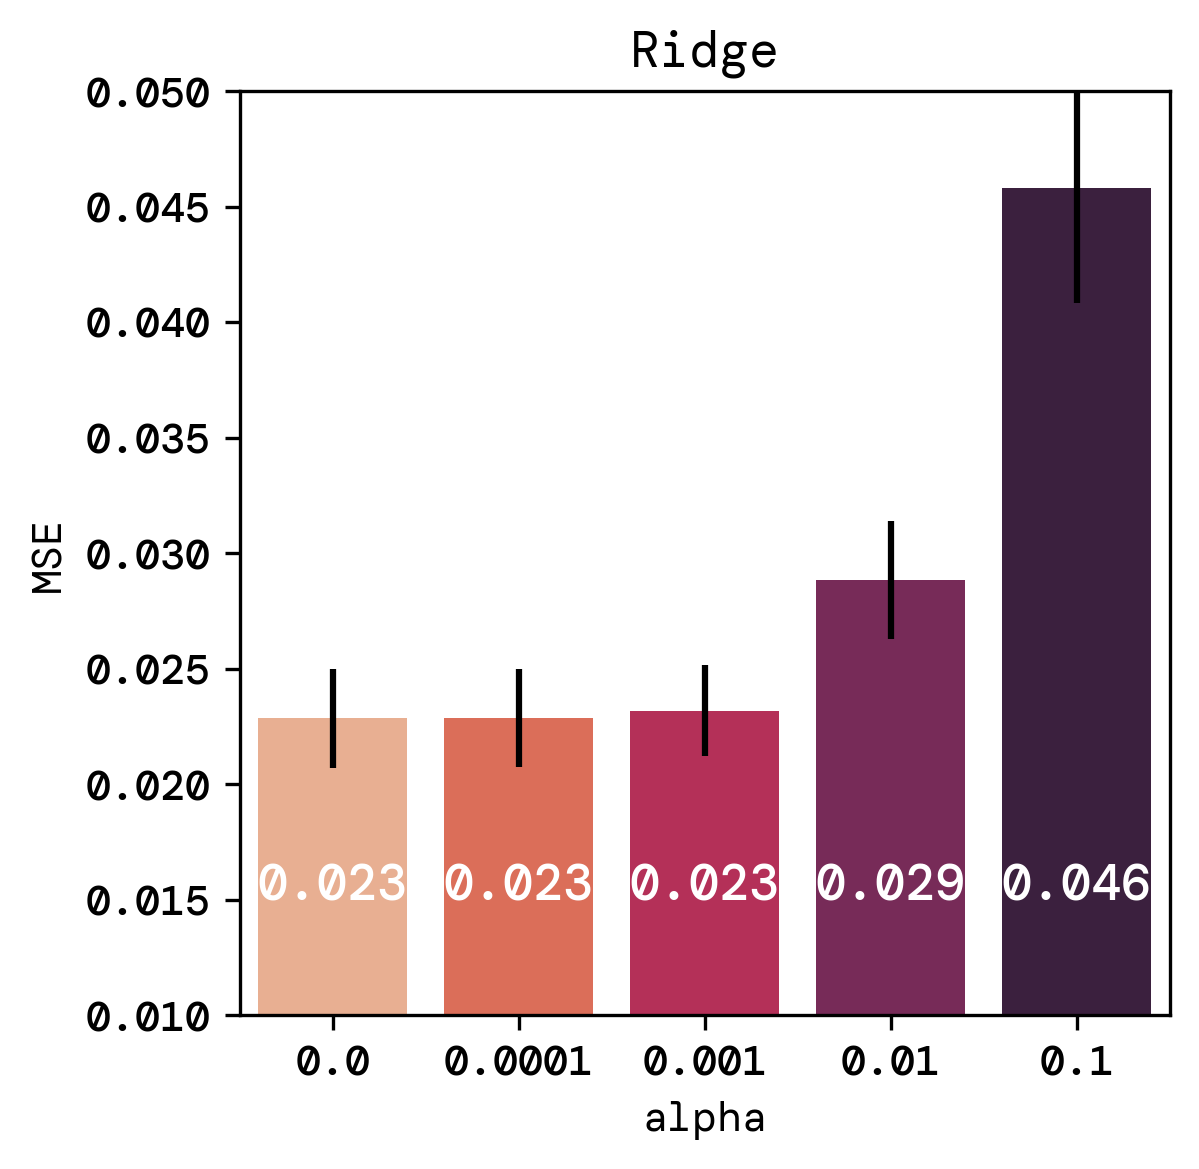

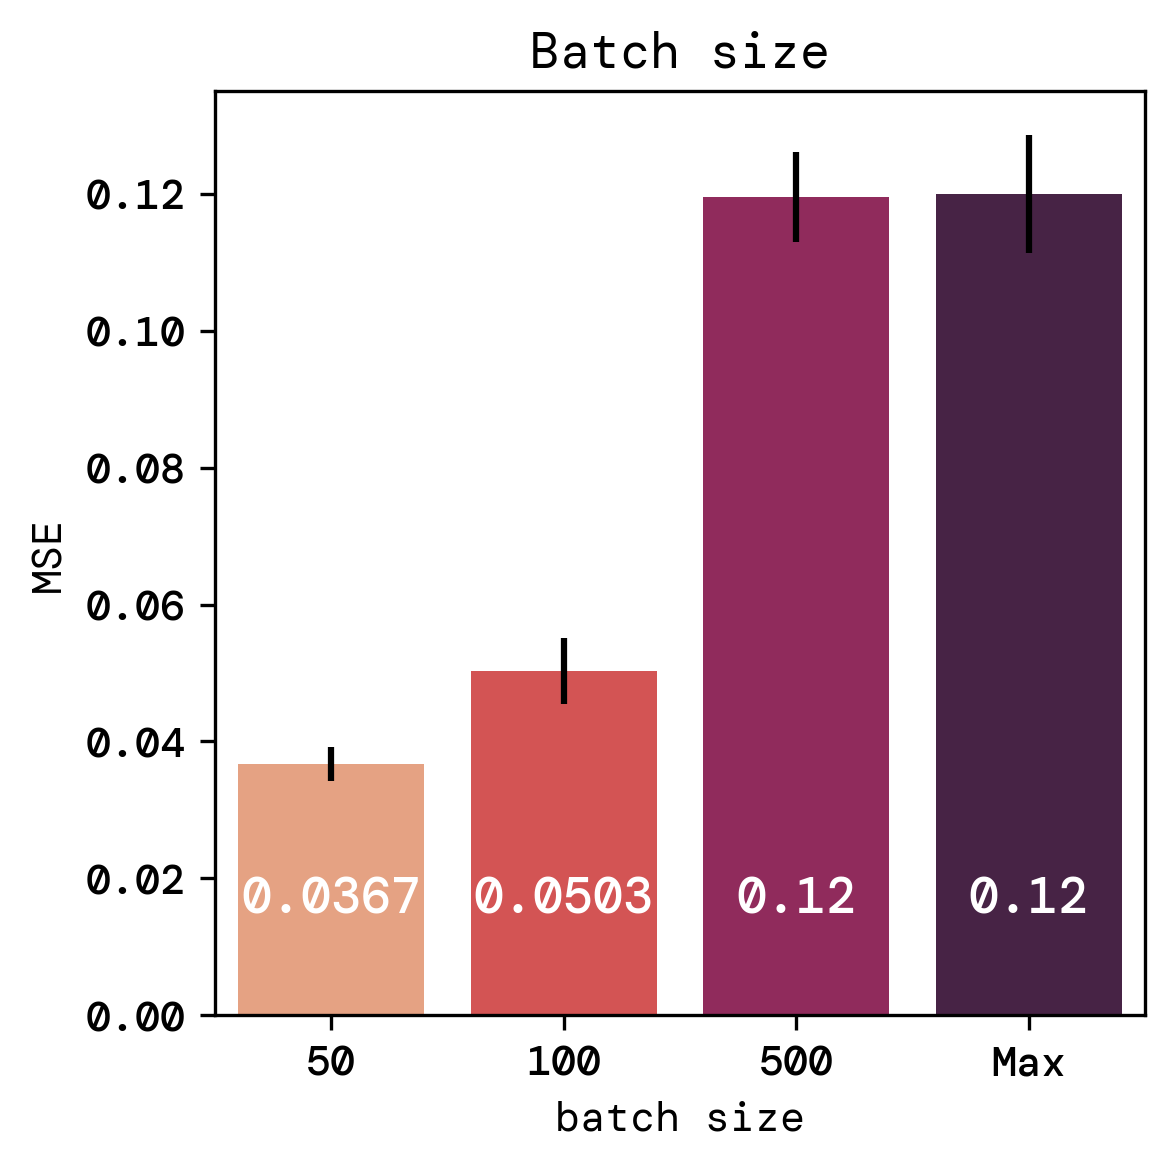

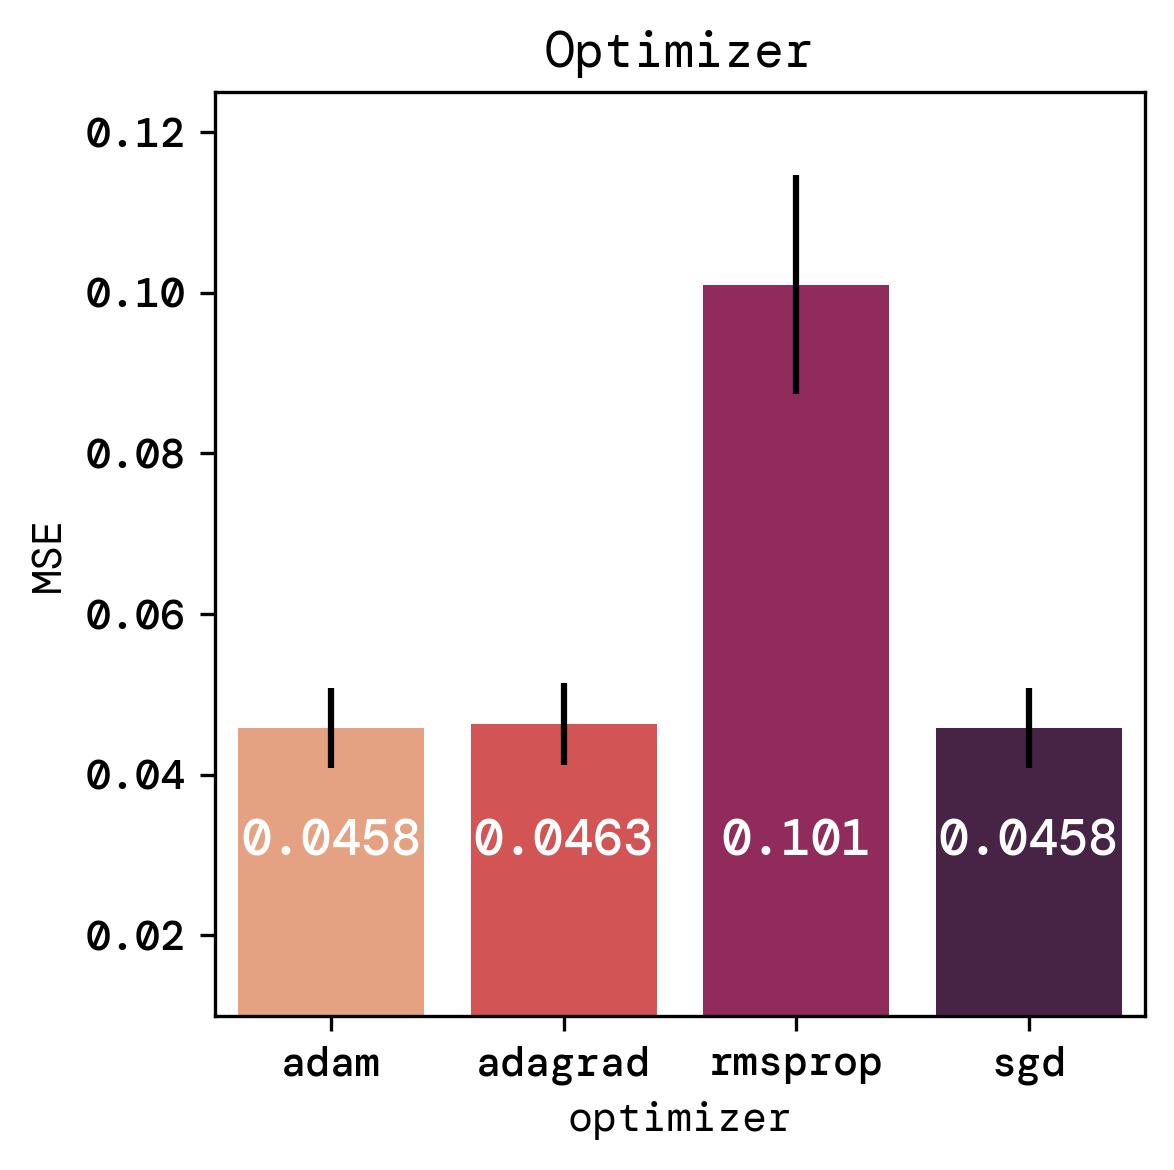

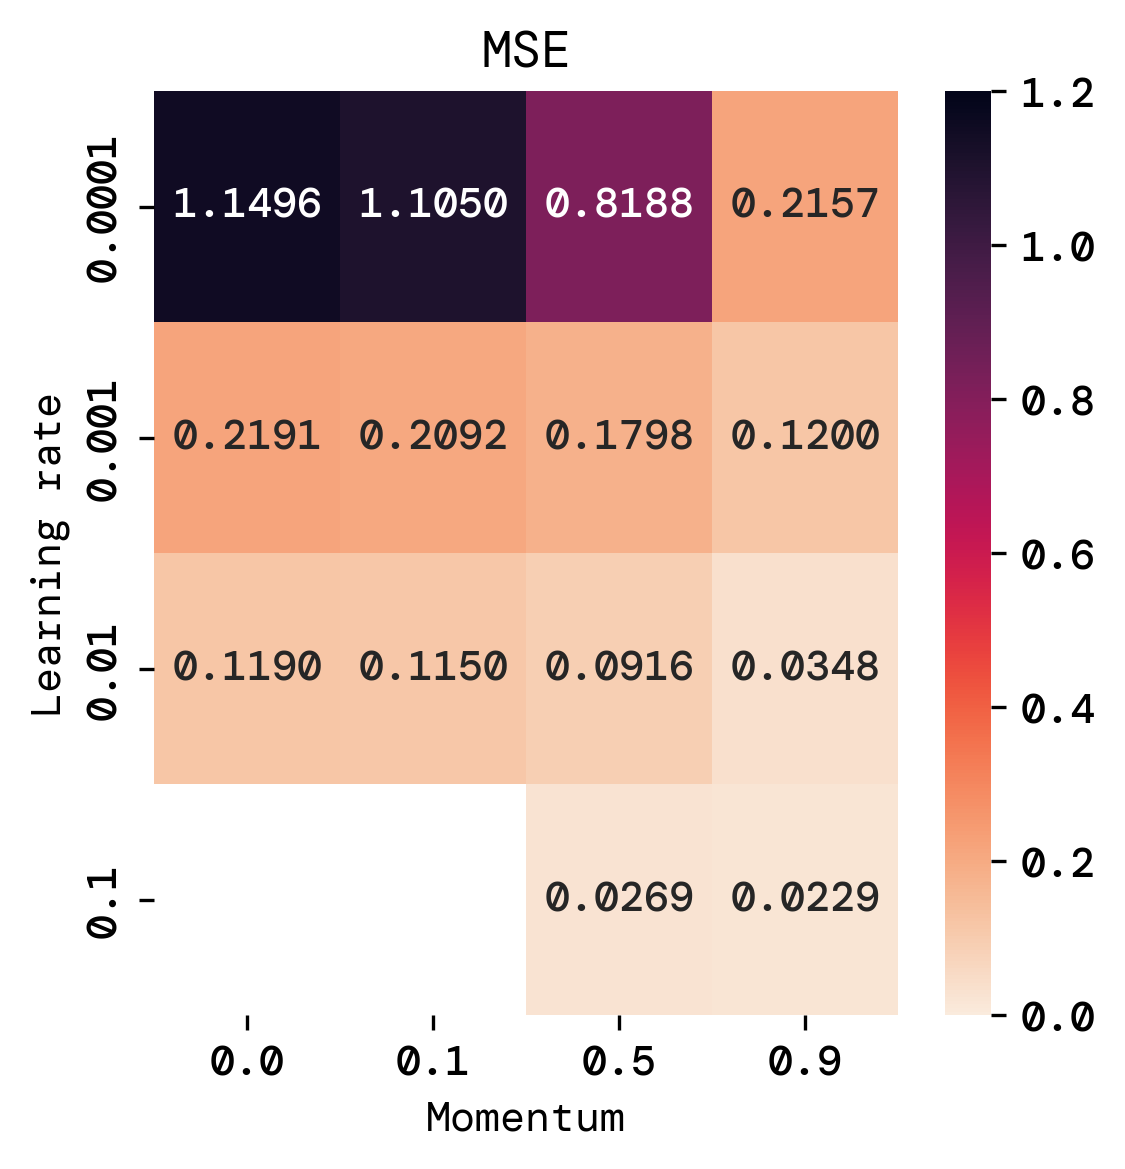

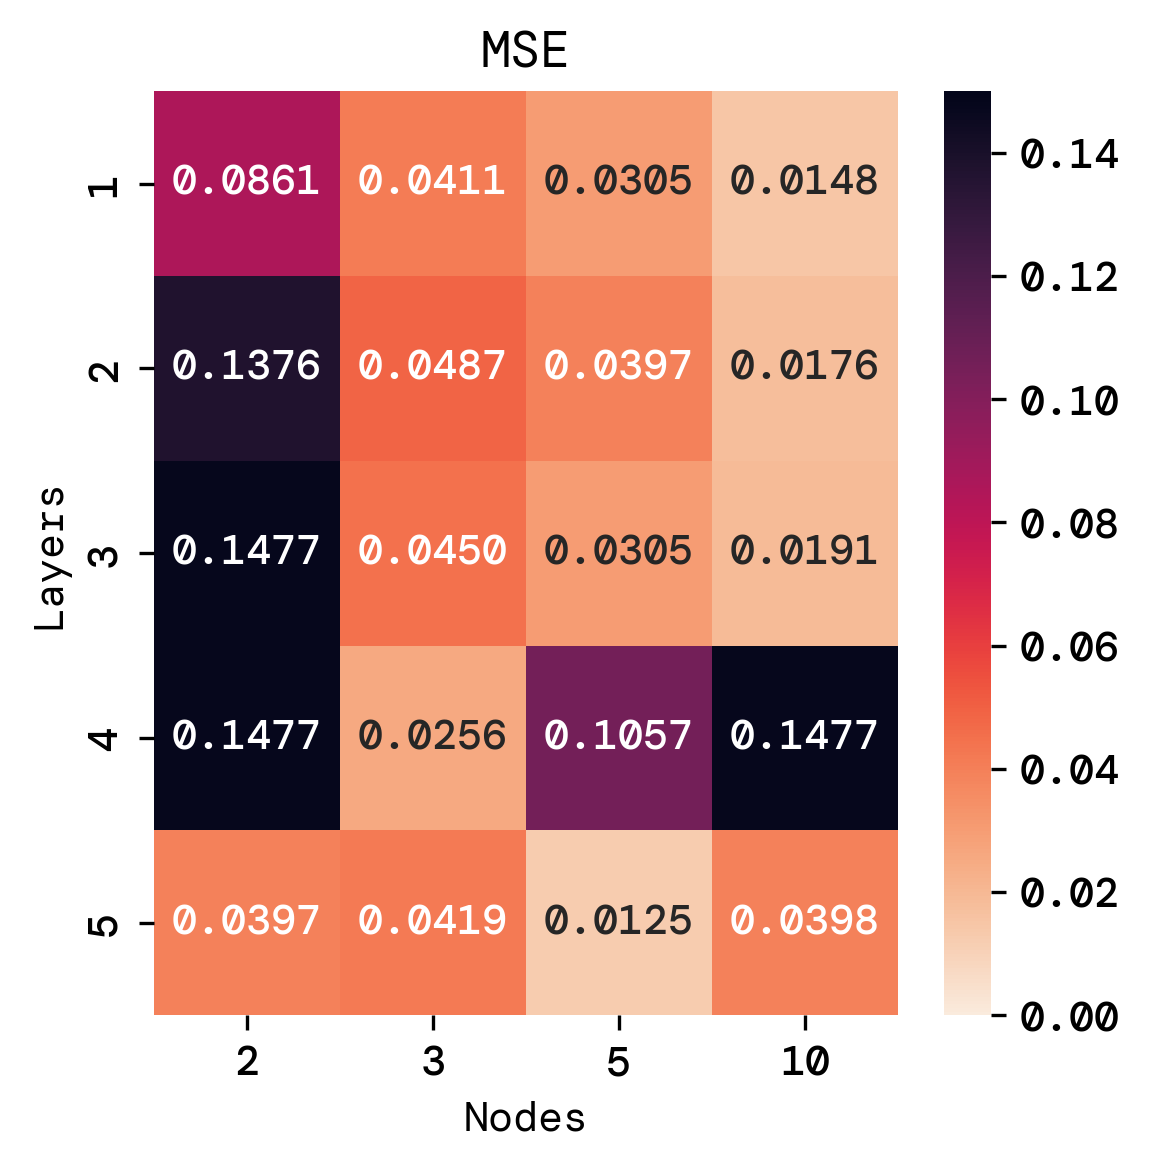

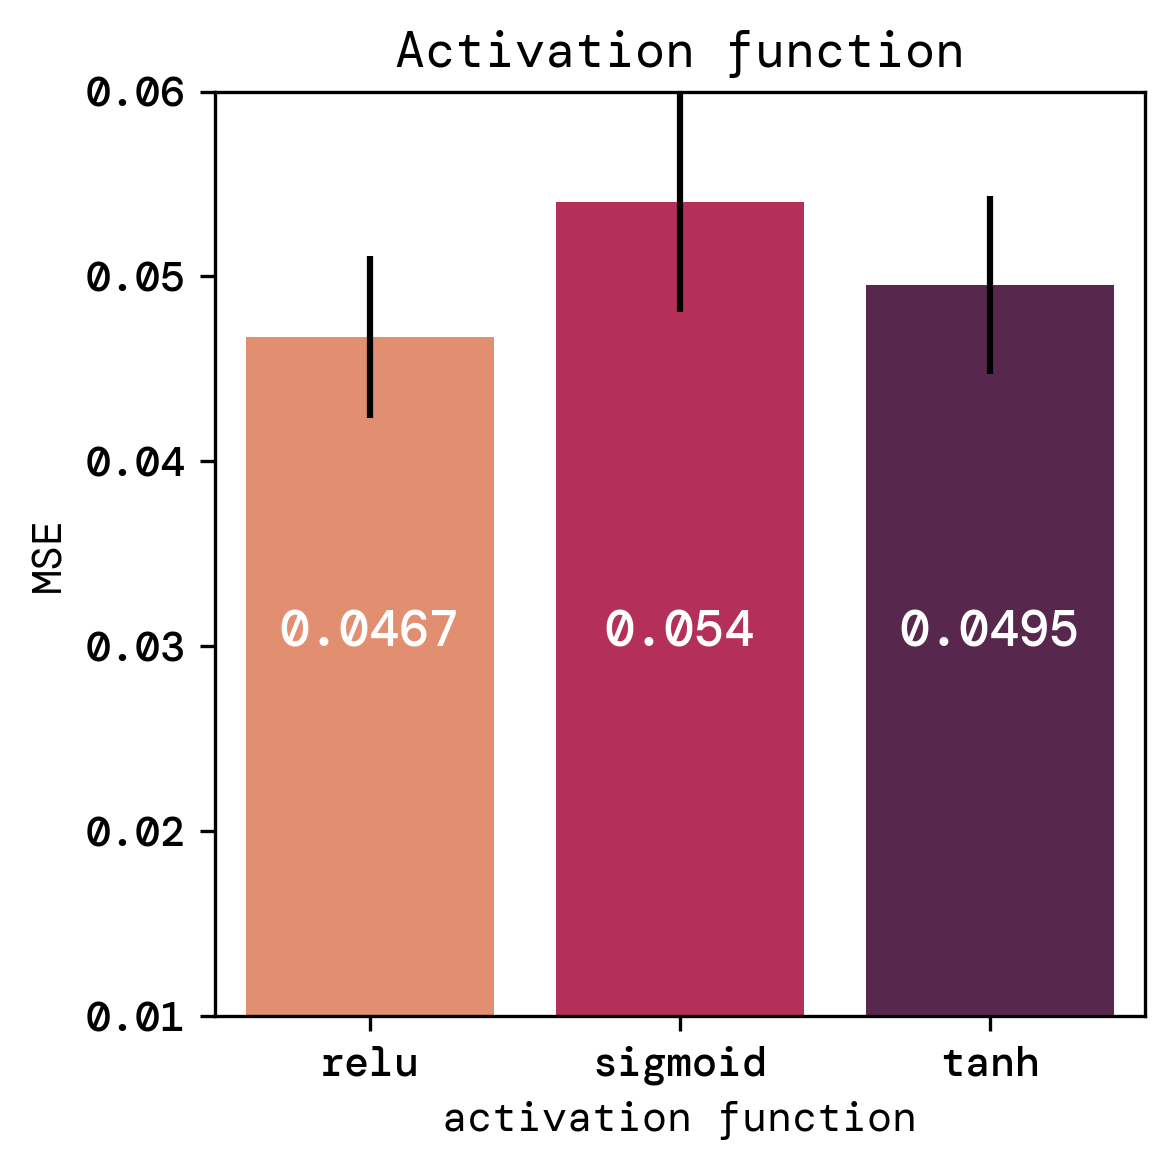

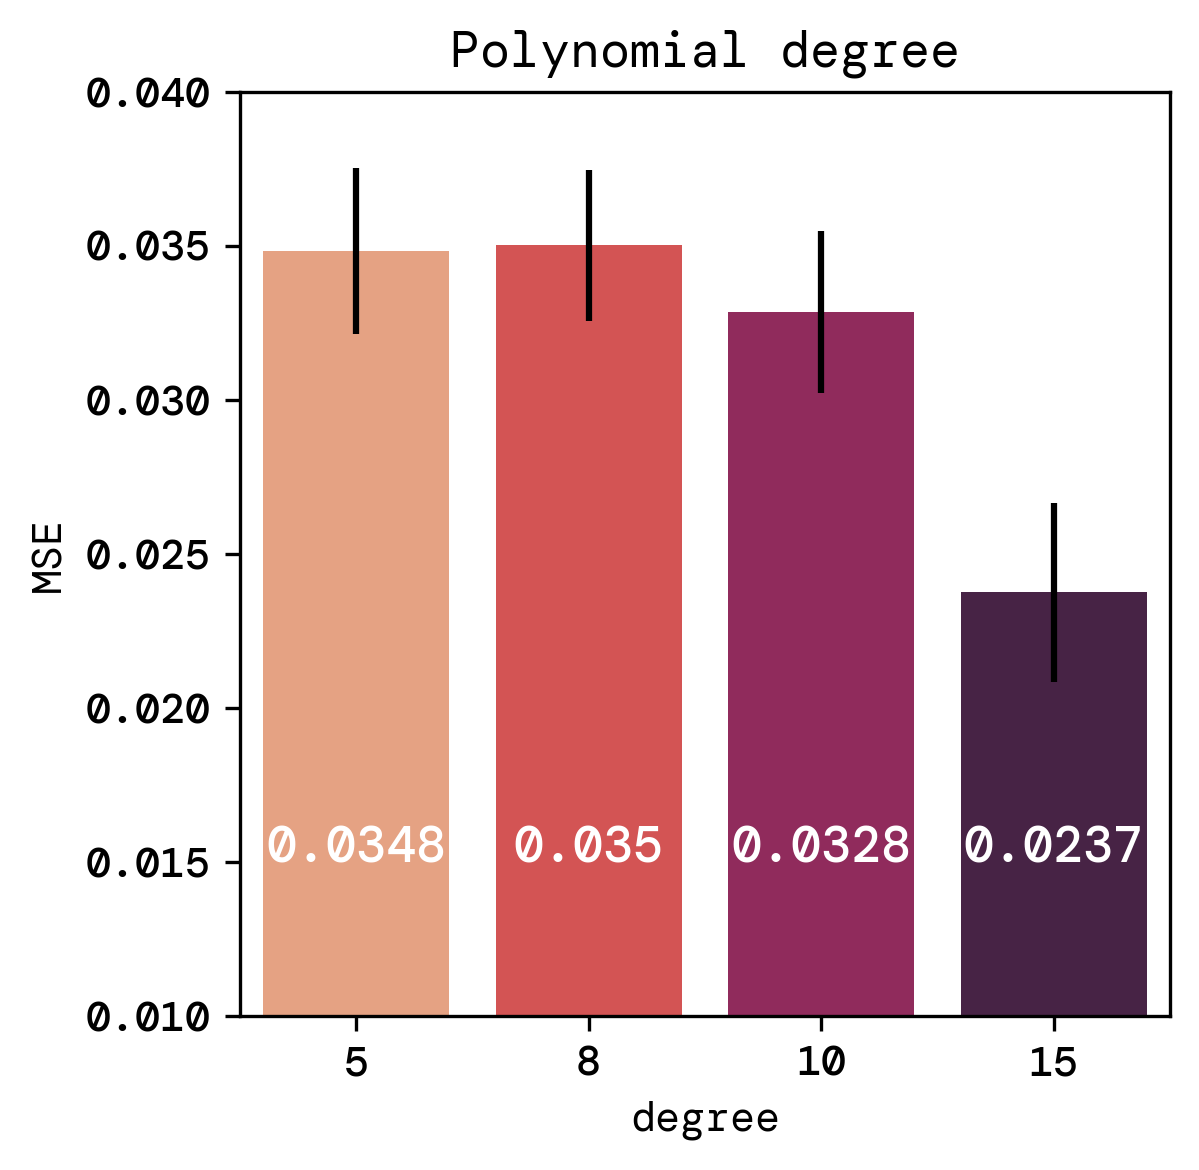

In [ ]:
plt.figure(figsize=(4,4))
ax = sns.barplot(x=alphas, y=scores_alpha[:,0], palette="rocket_r", yerr=scores_alpha[:,1])
ax.set_xlabel("alpha")
ax.set_ylabel("MSE")
ax.set_title("Ridge")
ax.set_ylim(0.01, 0.05)
ax.text(0, 0.015, f"{scores_alpha[0,0]:.2}", ha='center',  fontsize=12, color='white')
ax.text(1, 0.015, f"{scores_alpha[1,0]:.2}", ha='center',  fontsize=12, color='white')
ax.text(2, 0.015, f"{scores_alpha[2,0]:.2}", ha='center',  fontsize=12, color='white')
ax.text(3, 0.015, f"{scores_alpha[3,0]:.2}", ha='center',  fontsize=12, color='white')
ax.text(4, 0.015, f"{scores_alpha[4,0]:.2}", ha='center',  fontsize=12, color='white')
plt.savefig("../runsAndFigures/MSE_alpha.png",bbox_inches='tight')
plt.show()


plt.figure(figsize=(4,4))
batch_sizes = [ 50, 100, 500, "Max" ]
ax = sns.barplot(x=batch_sizes, y=score_batches[:,0], yerr=score_batches[:,1], palette="rocket_r")
ax.set_xlabel("batch size")
ax.set_ylabel("MSE")
ax.set_title("Batch size")
ax.text(0, 0.015, f"{score_batches[0,0]:.3}", ha='center',  fontsize=12, color='white')
ax.text(1, 0.015, f"{score_batches[1,0]:.3}", ha='center',  fontsize=12, color='white')
ax.text(2, 0.015, f"{score_batches[2,0]:.3}", ha='center',  fontsize=12, color='white')
ax.text(3, 0.015, f"{score_batches[3,0]:.3}", ha='center',  fontsize=12, color='white')
plt.savefig("../runsAndFigures/MSE_batch.png",bbox_inches='tight')
plt.show()


plt.figure(figsize=(4,4))
ax = sns.barplot(x=optimizer_names, y=scores_optimizer[:,0], yerr=scores_optimizer[:,1], palette="rocket_r")
ax.set_xlabel("optimizer")
ax.set_ylabel("MSE")
ax.set_title("Optimizer")
ax.set_ylim(0.01, 0.125)
ax.text(0, 0.03, f"{scores_optimizer[0,0]:.3}", ha='center',  fontsize=12, color='white')
ax.text(1, 0.03, f"{scores_optimizer[1,0]:.3}", ha='center',  fontsize=12, color='white')
ax.text(2, 0.03, f"{scores_optimizer[2,0]:.3}", ha='center',  fontsize=12, color='white')
ax.text(3, 0.03, f"{scores_optimizer[3,0]:.3}", ha='center',  fontsize=12, color='white')
plt.savefig("../runsAndFigures/MSE_optimizer.png",bbox_inches='tight')
plt.show()

plt.figure(figsize=(4,4))
ax = sns.heatmap(scores_lr_gamma, annot=True, fmt=".4f", cmap="rocket_r", vmax=1.2, vmin=0.0)
ax.set_title("MSE")
ax.set_xlabel("Momentum")
ax.set_xticklabels(gammas)
ax.set_ylabel("Learning rate")
ax.set_yticklabels(etas)
plt.savefig("../runsAndFigures/MSE_lr_gamma.png",bbox_inches='tight')
plt.show()


plt.figure(figsize=(4,4))
ax = sns.heatmap(scores_layers_nodes, annot=True, fmt=".4f", cmap="rocket_r", vmax=0.15, vmin=0.0)
ax.set_title("MSE")
ax.set_xlabel("Nodes")
ax.set_xticklabels(n_nodes)
ax.set_ylabel("Layers")
ax.set_yticklabels(n_layers)
plt.savefig("../runsAndFigures/MSE_layers_nodes.png",bbox_inches='tight')
plt.show()


plt.figure(figsize=(4,4))
activs_names = ["relu", "sigmoid", "tanh"]
ax = sns.barplot(x=activs_names, y=scores_activs[:,0], yerr=scores_activs[:,1], palette="rocket_r")
ax.set_xlabel("activation function")
ax.set_ylabel("MSE")
ax.set_title("Activation function")
ax.set_ylim(0.01, 0.06)
ax.text(0, 0.03, f"{scores_activs[0,0]:.3}", ha='center',  fontsize=12, color='white')
ax.text(1, 0.03, f"{scores_activs[1,0]:.3}", ha='center',  fontsize=12, color='white')
ax.text(2, 0.03, f"{scores_activs[2,0]:.3}", ha='center',  fontsize=12, color='white')
plt.savefig("../runsAndFigures/MSE_activs.png",bbox_inches='tight')



plt.figure(figsize=(4,4))
ax = sns.barplot(x=degrees, y=scores_degree[:,0], yerr=scores_degree[:,1], palette="rocket_r")
ax.set_xlabel("degree")
ax.set_ylabel("MSE")
ax.set_title("Polynomial degree")
ax.set_ylim(0.01, 0.04)
ax.text(0, 0.015, f"{scores_degree[0,0]:.3}", ha='center',  fontsize=12, color='white')
ax.text(1, 0.015, f"{scores_degree[1,0]:.3}", ha='center',  fontsize=12, color='white')
ax.text(2, 0.015, f"{scores_degree[2,0]:.3}", ha='center',  fontsize=12, color='white')
ax.text(3, 0.015, f"{scores_degree[3,0]:.3}", ha='center',  fontsize=12, color='white')
plt.savefig("../runsAndFigures/MSE_degree.png",bbox_inches='tight')
plt.show()


